In [ ]:
# https://theailearner.com/2019/05/29/creating-a-crnn-model-to-recognize-text-in-an-image-part-2
# https://keras.io/examples/vision/handwriting_recognition
# https://github.com/pbcquoc/crnn
import sys
import tensorflow as tf
sys.path.append('..')
tf.get_logger().setLevel('ERROR')
APPROACH_NAME = 'CRNNxCTC'

# Check GPU working

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at:', device_name)
!nvcc -V

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


# Data input pipeline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/Thesis Resource/kaggle.json" ~/.kaggle/

!kaggle datasets download -d ngcthunhb/nomna-sr-patches
# !kaggle datasets download -d quandang/nomnaocr
!unzip -q /content/nomna-sr-patches.zip -d /content/NomNaDatasets
# !unzip -q /content/nomnaocr.zip -d /content/Datasets

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/ngcthunhb/nomna-sr-patches
License(s): unknown
 99% 2.49G/2.51G [00:19<00:00, 188MB/s]
100% 2.51G/2.51G [00:19<00:00, 140MB/s]


In [ ]:
!cp -r /content/NomNaDatasets/NomNaOCR/SR_Patches_Real_ESRGANx2/*.txt /content/NomNaDatasets/NomNaOCR/SR_Patches_SwinIRx2

In [ ]:
DATASET_DIR = r'/content/NomNaDatasets/MixedSR_Patches_RealESRGAN_RealCE/MixedSR_Patches_RealESRGAN_RealCE'
ALL_TRANSCRIPTS_PATH = f'{DATASET_DIR}/All.txt'
VALID_TRANSCRIPTS_PATH = f'{DATASET_DIR}/Validate.txt'
FONT_PATH = r'/content/NomNaDatasets/NomNaTong-Regular.ttf'

## Load and remove records with rare characters

In [ ]:
import os
import re
import numpy as np
import tensorflow as tf

import csv
import tensorflow as tf
from tqdm import tqdm


def ctc_decode(predictions, max_length):
    input_length = tf.ones(len(predictions)) * predictions.shape[1]
    preds_decoded = tf.keras.backend.ctc_decode(
        predictions,
        input_length = input_length,
        greedy = True,
    )[0][0][:, :max_length]

    return tf.where(
        preds_decoded == tf.cast(1, tf.int64),
        tf.cast(-1, tf.int64), # Treat [UNK] token same as blank label
        preds_decoded
    )


def update_tensor_column(tensor, values, col_idx):
    if col_idx < 0: raise ValueError("col_idx must be >= 0")
    rows = tf.range(tf.shape(tensor)[0])
    column = tf.zeros_like(rows) + col_idx
    idxs = tf.stack([rows, column], axis=1)
    return tf.tensor_scatter_nd_update(tensor, idxs, tf.squeeze(values, axis=-1))


def tokens2sparse(batch_tokens):
    idxs = tf.where(tf.logical_and(
        batch_tokens != 0, # For [PAD] token
        batch_tokens != -1 # For blank label if use_ctc_decode
    ))
    return tf.SparseTensor(
        tf.cast(idxs, tf.int64),
        tf.gather_nd(batch_tokens, idxs),
        tf.cast(tf.shape(batch_tokens), tf.int64)
    )


def sparse2dense(tensor, shape):
    tensor = tf.sparse.reset_shape(tensor, shape)
    tensor = tf.sparse.to_dense(tensor, default_value=-1)
    tensor = tf.cast(tensor, tf.float32)
    return tensor


def rec2csv(file_name, patch_list, data_handler, model, use_ctc_decode=False):
    with open(file_name, 'w', encoding='utf-8', newline='') as f:
        writer = csv.writer(f)
        for img_path in tqdm(patch_list):
            image = data_handler.process_image(img_path)
            pred_tokens = model.predict(tf.expand_dims(image, axis=0))
            pred_labels = data_handler.tokens2texts(pred_tokens, use_ctc_decode)
            writer.writerow([img_path, pred_labels[0]])
from string import printable
from collections import defaultdict, Counter


class DataImporter:
    def __init__(self, dataset_dir, labels_path, min_length=4):
        self.img_paths, self.labels = [], []
        with open(labels_path, 'r', encoding='utf-8') as file:
            for line in file:
                img_name, text = line.rstrip('\n').split('\t')
                img_path = os.path.join(dataset_dir, img_name)
                text = text.strip().lower()

                if os.path.getsize(img_path) and len(text) >= min_length and self.is_clean_text(text):
                    self.img_paths.append(img_path)
                    self.labels.append(text)

        assert len(self.img_paths) == len(self.labels), 'img_paths and labels must have same size'
        self.img_paths = np.array(self.img_paths)
        self.labels = np.array(self.labels)
        self.vocabs = dict(Counter(''.join(self.labels)).most_common())
        self.size = len(self.labels)


    def remove_rare_chars(self, threshold=1):
        if threshold < 2: return self
        rare_chars, idxs_to_remove = [], []
        is_satisfy_threshold = True

        # Vocabs need to be sorted (for faster checking)
        for char, freq in reversed(self.vocabs.items()):
            if freq < threshold: rare_chars.append(char)
            else: break

        for idx, label in enumerate(self.labels):
            if any((char in label) for char in rare_chars):
                idxs_to_remove.append(idx)

        # Remove sentences containing rare characters and recalculate the vocab frequencies
        idxs_to_remove = np.array(idxs_to_remove)
        self.img_paths = np.delete(self.img_paths, idxs_to_remove)
        self.labels = np.delete(self.labels, idxs_to_remove)

        assert len(self.img_paths) == len(self.labels), 'img_paths and labels must have same size'
        self.vocabs = dict(Counter(''.join(self.labels)).most_common())
        self.size = len(self.labels)

        # Check if there are still rare characters after removing sentences
        smallest_freq = threshold + 1 # If vocabs is empty, the smallest frequency always > threshold
        if len(self.vocabs) >= 1: smallest_freq = list(self.vocabs.values())[-1]
        return self.remove_rare_chars(threshold) if smallest_freq < threshold else self


    def is_clean_text(self, text):
        not_nom_chars = r'\sáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ'
        pattern = re.compile(f'[{not_nom_chars}{re.escape(printable)}]')
        return not bool(re.search(pattern, text.lower()))


    def __str__(self):
        return (
            f'Samples count (not include Latin letters, numbers, punctuations):'
            f'\n- Number of images found: {len(self.img_paths)}'
            f'\n- Number of labels found: {len(self.labels)}'
            f'\n- Number of unique characters: {len(self.vocabs)}'
            f'\n- Characters present: {self.vocabs}'
        )


class DataHandler:
    def __init__(self, dataset: DataImporter, img_size: tuple, padding_char, start_char='', end_char=''):
        self.img_paths = dataset.img_paths
        self.labels = dataset.labels
        self.vocabs = dataset.vocabs

        self.img_size = img_size
        self.padding_char = padding_char
        self.start_char = start_char
        self.end_char = end_char

        # Mapping characters to integers
        vocabulary = list(self.vocabs)
        if start_char != '' and end_char != '': vocabulary += [start_char, end_char]
        self.char2num = tf.keras.layers.StringLookup(vocabulary=vocabulary, mask_token=padding_char)

        # Mapping integers back to original characters
        self.num2char = tf.keras.layers.StringLookup(
            vocabulary = self.char2num.get_vocabulary(),
            mask_token = padding_char,
            invert = True,
        )

        self.max_length = max([len(label) for label in self.labels])
        self.start_token, self.end_token = None, None
        self.start_concat, self.end_concat = [], []
        mask_idxs = [0, 1] # For [PAD] and [UNK] tokens

        if self.start_char != '' and self.end_char != '':
            self.start_token = self.char2num(start_char)
            self.end_token = self.char2num(end_char)
            self.start_concat = [self.start_token]
            self.end_concat = [self.end_token]
            self.max_length += 2 # For [START] and [END] tokens
            mask_idxs.append(self.start_token)

        # Prevent from generating padding, unknown, or start when using argmax in model.predict
        token_mask = np.zeros([self.char2num.vocab_size()], dtype=bool)
        token_mask[np.array(mask_idxs)] = True
        self.token_mask = token_mask


    def distortion_free_resize(self, image, align_top=True):
        h, w = self.img_size
        image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

        # Check the amount of padding needed to be done.
        pad_height = h - tf.shape(image)[0]
        pad_width = w - tf.shape(image)[1]
        if pad_height == 0 and pad_width == 0: return image

        # Only necessary if you want to do same amount of padding on both sides.
        if pad_height % 2 != 0:
            height = pad_height // 2
            pad_height_top, pad_height_bottom = height + 1, height
        else:
            pad_height_top = pad_height_bottom = pad_height // 2

        if pad_width % 2 != 0:
            width = pad_width // 2
            pad_width_left, pad_width_right = width + 1, width
        else:
            pad_width_left = pad_width_right = pad_width // 2

        return tf.pad(image, paddings=[
            [0, pad_height_top + pad_height_bottom] if align_top else [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ], constant_values=255) # Pad with white color


    def process_image(self, img_path, img_align_top=True):
        image = tf.io.read_file(img_path)
        image = tf.image.decode_jpeg(image, 3)
        image = self.distortion_free_resize(image, img_align_top)
        image = tf.cast(image, tf.float32) / 255.0
        return image


    def process_label(self, label):
        label = self.char2num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
        label = tf.concat([self.start_concat, label, self.end_concat], 0)
        label_length = tf.shape(label, tf.int64)[0]
        label = tf.pad(
            label,
            paddings = [[0, self.max_length - label_length]],
            constant_values = 0 # Pad with padding token
        )
        return label


    def prepare_tf_dataset(self, idxs, batch_size, drop_remainder=False, img_align_top=True, use_cache=True):
        self.batch_size = batch_size




        dataset = tf.data.Dataset.from_tensor_slices((self.img_paths[idxs], self.labels[idxs])).map(
            lambda img_path, label: (
                self.process_image(img_path, img_align_top),
                self.process_label(label)
            ), num_parallel_calls = tf.data.AUTOTUNE
        ).batch(batch_size, drop_remainder=drop_remainder)

        # When use .cache(), everything before is saved in the memory. It gives a
        # significant boost in speed but only if you can get your hands on a larger RAM
        if use_cache: dataset = dataset.cache()
        return dataset.prefetch(tf.data.AUTOTUNE)


    def tokens2texts(self, batch_tokens, use_ctc_decode=False):
        batch_texts = []
        if use_ctc_decode:
            batch_tokens = ctc_decode(batch_tokens, self.max_length)

        # Iterate over the results and get back the text
        for tokens in batch_tokens:
            indices = tf.gather(tokens, tf.where(tf.logical_and(
                tokens != 0, # For [PAD] token
                tokens != -1 # For blank label if use_ctc_decode
            )))

            # Convert to string
            text = tf.strings.reduce_join(self.num2char(indices))
            text = text.numpy().decode('utf-8')
            text = text.replace(self.start_char, '').replace(self.end_char, '')
            batch_texts.append(text)
        return batch_texts
dataset = DataImporter(DATASET_DIR, ALL_TRANSCRIPTS_PATH, min_length=1)
print(dataset)

Samples count (not include Latin letters, numbers, punctuations):
- Number of images found: 75672
- Number of labels found: 75672
- Number of unique characters: 7479
- Characters present: {'之': 15046, '以': 9592, '人': 7100, '月': 6892, '十': 6504, '不': 6290, '年': 6024, '帝': 5378, '有': 5082, '二': 4984, '其': 4898, '大': 4624, '日': 4520, '為': 4456, '等': 4164, '爲': 4036, '而': 3946, '國': 3892, '一': 3862, '軍': 3760, '王': 3744, '太': 3742, '公': 3660, '天': 3658, '子': 3584, '三': 3568, '官': 3566, '兵': 3556, '明': 3442, '曰': 3360, '於': 3258, '至': 3250, '使': 3194, '時': 3124, '者': 3122, '阮': 3100, '事': 3042, '臣': 3038, '也': 2996, '黎': 2818, '及': 2768, '文': 2748, '皇': 2718, '上': 2716, '如': 2704, '是': 2598, '行': 2516, '安': 2500, '五': 2480, '士': 2480, '中': 2434, '元': 2414, '四': 2398, '命': 2332, '下': 2330, '自': 2322, '民': 2240, '所': 2226, '宗': 2190, '書': 2094, '州': 2088, '六': 2058, '得': 2056, '道': 2030, '武': 2016, '于': 1998, '生': 1976, '都': 1914, '吏': 1892, '城': 1878, '正': 1844, '将': 1814, '知': 1798, '各': 17

## Data constants and input pipeline

In [ ]:
HEIGHT, WIDTH = 432, 48
PADDING_CHAR = '[PAD]'
BATCH_SIZE = 64

In [ ]:
data_handler = DataHandler(dataset, img_size=(HEIGHT, WIDTH), padding_char=PADDING_CHAR)
NUM_VALIDATE = DataImporter(DATASET_DIR, VALID_TRANSCRIPTS_PATH, min_length=1).size
VOCAB_SIZE = data_handler.char2num.vocab_size()

## Visualize the data

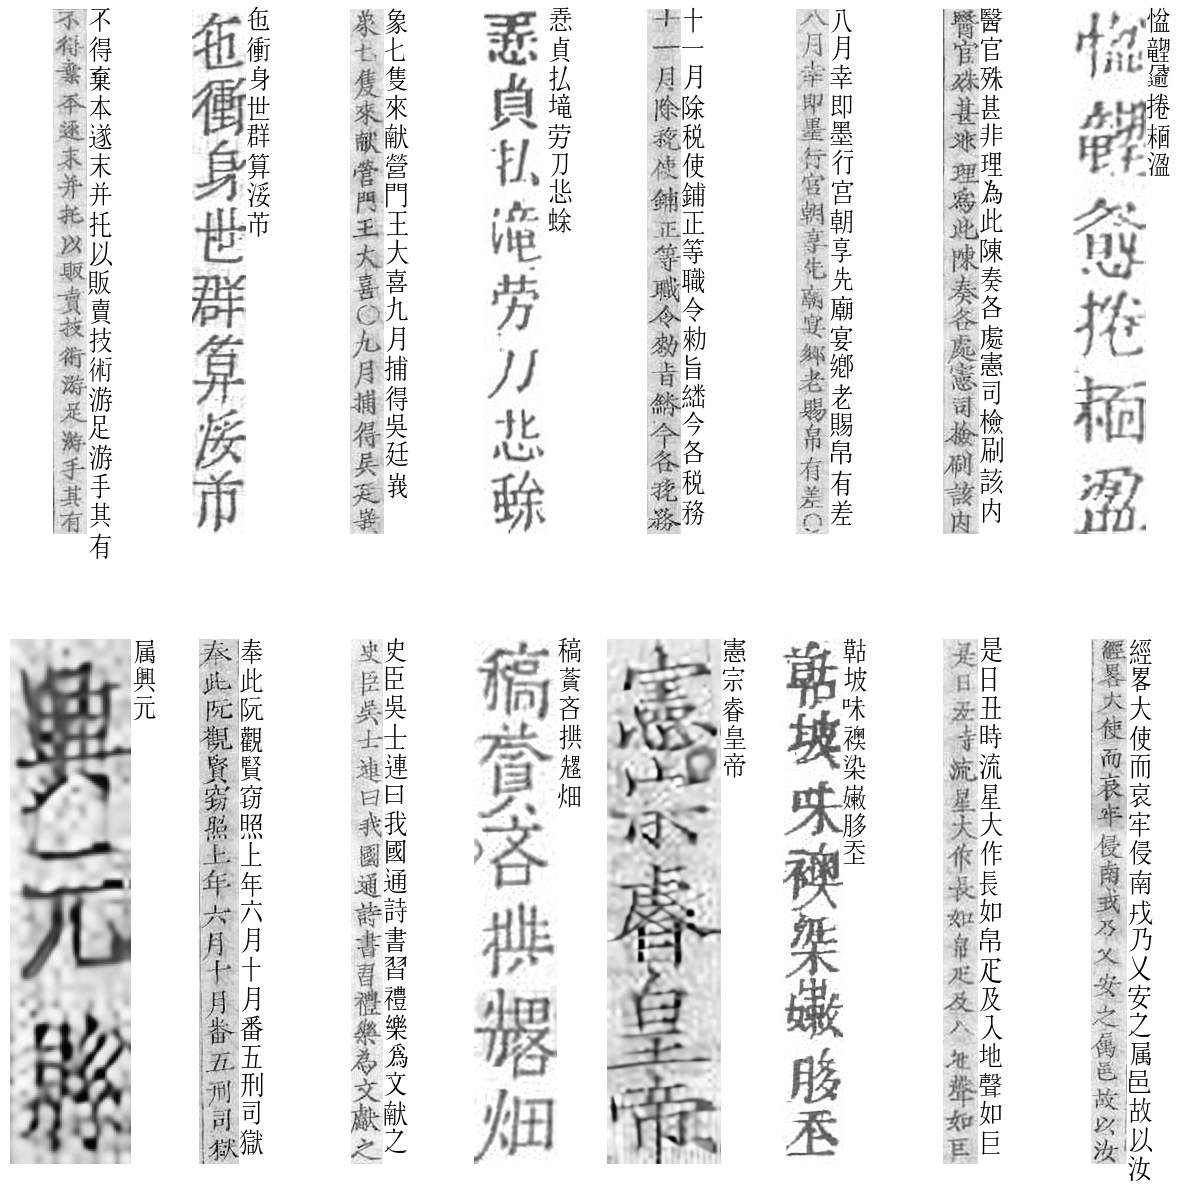

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.font_manager import FontProperties


def draw_predicted_text(label, pred_label, fontdict, width, height):
    label = label.replace('[UNK]', '?')
    label_length, pred_length = len(label), len(pred_label)

    if pred_label == label:
        fontdict['color'] = 'green'
        plt.text(width, 0, '\n'.join(pred_label), fontdict=fontdict)
        return

    pred_start, start, end = 0, 0, 0
    while start <= end < label_length:
        text_y = end * height / label_length
        actual_char = '[UNK]' if label[end] == '?' else label[end]

        if label[start:end + 1] in pred_label[pred_start:pred_length]:
            fontdict['color'] = 'dodgerblue'
            plt.text(width, text_y, actual_char, fontdict=fontdict)
        else:
            if end < pred_length and end + 1 < label_length and pred_label[end] == label[end + 1]:
                fontdict['color'] = 'gray'
                plt.text(width, text_y, actual_char, fontdict=fontdict)
            elif end < pred_length:
                fontdict['color'] = 'red'
                plt.text(width, text_y, pred_label[end], fontdict=fontdict)
                fontdict['color'] = 'black'
                plt.text(width * 2, text_y, actual_char, fontdict=fontdict)
            else:
                fontdict['color'] = 'gray'
                plt.text(width, text_y, actual_char, fontdict=fontdict)

            pred_start = end
            start = end + 1
        end += 1


def visualize_images_labels(
    img_paths,
    labels, # shape == (batch_size, max_length)
    pred_labels = None, # shape == (batch_size, max_length)
    figsize = (15, 8),
    subplot_size = (2, 8), # tuple: (rows, columns) to display
    legend_loc = None, # Only for predictions,
    annotate_loc = None, # Only for predictions
    font_path = None
):
    nrows, ncols = subplot_size
    num_of_labels = len(labels)
    assert len(img_paths) == num_of_labels, 'img_paths and labels must have same number of items'
    assert nrows * ncols <= num_of_labels, f'nrows * ncols must be <= {num_of_labels}'
    fontdict = {
        'fontproperties': FontProperties(fname=font_path),
        'fontsize': 18,
        'color': 'black',
        'verticalalignment': 'top',
        'horizontalalignment': 'left'
    }

    plt.figure(figsize=figsize)
    for i in range(min(nrows * ncols, num_of_labels)):
        plt.subplot(nrows, ncols, i + 1)
        image, label = plt.imread(img_paths[i]), labels[i]
        height, width, channel = image.shape
        # print(height, width, channel)
        plt.imshow(image)

        fontdict['color'] = 'black'  # Reset the color
        if pred_labels: draw_predicted_text(label, pred_labels[i], fontdict, width, height)
        else: plt.text(width, 0, '\n'.join(label), fontdict=fontdict)
        plt.axis('off')

    if legend_loc and annotate_loc and pred_labels:
        plt.subplots_adjust(left=0, right=0.75)
        plt.legend(handles=[
            Patch(color='green', label='Full match'),
            Patch(color='dodgerblue', label='Character match'),
            Patch(color='red', label='Wrong prediction'),
            Patch(color='black', label='Actual character'),
            Patch(color='gray', label='Missing position'),
        ], loc=legend_loc)

        annotate_text = [f'{idx + 1:02d}. {text}' for idx, text in enumerate(pred_labels)]
        plt.annotate(
            f'Model predictions:\n{chr(10).join(annotate_text)}',
            fontproperties = FontProperties(fname=font_path),
            xycoords = 'axes fraction',
            fontsize = 14,
            xy = annotate_loc,
        )


def plot_training_results(history, save_name, figsize=(16, 14), subplot_size=(2, 2)):
    nrows, ncols = subplot_size
    if 'lr' in history.keys(): del history['lr']
    assert nrows * ncols <= len(history), f'nrows * ncols must be <= {len(history)}'
    fig = plt.figure(figsize=figsize)

    for idx, name in enumerate(history):
        if 'val' in name: continue
        plt.subplot(nrows, ncols, idx + 1)
        plt.plot(history[name], linestyle='solid', marker='o', color='crimson', label='Train')
        plt.plot(history[f'val_{name}'], linestyle='solid', marker='o', color='dodgerblue', label='Validation')
        plt.xlabel('Epochs', fontsize=14)
        plt.ylabel(name, fontsize=14)

        title = name.replace('acc', 'accuracy')\
                    .replace('seq_', 'sequence_')\
                    .replace('char_', 'character_')\
                    .replace('lev_', 'levenshtein_')\
                    .replace('edit_', 'levenshtein_')\
                    .replace('_', ' ').capitalize()
        plt.title(title, fontsize=18)
        plt.legend(loc='best')

    fig.savefig(save_name, bbox_inches='tight')
    plt.show()
visualize_images_labels(
    dataset.img_paths,
    dataset.labels,
    figsize = (15, 15),
    subplot_size = (2, 8),
    font_path = FONT_PATH
)

In [ ]:
import torch
from torch import nn
import math

# SR Arch: SRCNN

In [ ]:
import torch
from torch import nn
import math

class SRCNN(nn.Module):
    def __init__(self) -> None:
        super(SRCNN, self).__init__()
        # Feature extraction layer.
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, (9, 9), (1, 1), (4, 4)),
            nn.ReLU(True)
        )

        # Non-linear mapping layer.
        self.map = nn.Sequential(
            nn.Conv2d(64, 32, (5, 5), (1, 1), (2, 2)),
            nn.ReLU(True)
        )

        # Rebuild the layer.
        self.reconstruction = nn.Conv2d(32, 1, (5, 5), (1, 1), (2, 2))

        # Initialize model weights.
        self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self._forward_impl(x)

    # Support torch.script function.
    def _forward_impl(self, x: torch.Tensor) -> torch.Tensor:
        out = self.features(x)
        out = self.map(out)
        out = self.reconstruction(out)

        return out

    # The filter weight of each layer is a Gaussian distribution with zero mean and
    # standard deviation initialized by random extraction 0.001 (deviation is 0)
    def _initialize_weights(self) -> None:
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight.data, 0.0, math.sqrt(2 / (module.out_channels * module.weight.data[0][0].numel())))
                nn.init.zeros_(module.bias.data)

        nn.init.normal_(self.reconstruction.weight.data, 0.0, 0.001)
        nn.init.zeros_(self.reconstruction.bias.data)

# SR Arch: SRResnet

In [ ]:
from torch.nn.modules.batchnorm import _BatchNorm
from torch.nn import init as init

@torch.no_grad()
def default_init_weights(module_list, scale=1, bias_fill=0, **kwargs):
    """Initialize network weights.

    Args:
        module_list (list[nn.Module] | nn.Module): Modules to be initialized.
        scale (float): Scale initialized weights, especially for residual
            blocks. Default: 1.
        bias_fill (float): The value to fill bias. Default: 0
        kwargs (dict): Other arguments for initialization function.
    """
    if not isinstance(module_list, list):
        module_list = [module_list]
    for module in module_list:
        for m in module.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, **kwargs)
                m.weight.data *= scale
                if m.bias is not None:
                    m.bias.data.fill_(bias_fill)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, **kwargs)
                m.weight.data *= scale
                if m.bias is not None:
                    m.bias.data.fill_(bias_fill)
            elif isinstance(m, _BatchNorm):
                init.constant_(m.weight, 1)
                if m.bias is not None:
                    m.bias.data.fill_(bias_fill)

def make_layer(basic_block, num_basic_block, **kwarg):
    """Make layers by stacking the same blocks.

    Args:
        basic_block (nn.module): nn.module class for basic block.
        num_basic_block (int): number of blocks.

    Returns:
        nn.Sequential: Stacked blocks in nn.Sequential.
    """
    layers = []
    for _ in range(num_basic_block):
        layers.append(basic_block(**kwarg))
    return nn.Sequential(*layers)

class ResidualBlockNoBN(nn.Module):
    """Residual block without BN.

    Args:
        num_feat (int): Channel number of intermediate features.
            Default: 64.
        res_scale (float): Residual scale. Default: 1.
        pytorch_init (bool): If set to True, use pytorch default init,
            otherwise, use default_init_weights. Default: False.
    """

    def __init__(self, num_feat=64, res_scale=1, pytorch_init=False):
        super(ResidualBlockNoBN, self).__init__()
        self.res_scale = res_scale
        self.conv1 = nn.Conv2d(num_feat, num_feat, 3, 1, 1, bias=True)
        self.conv2 = nn.Conv2d(num_feat, num_feat, 3, 1, 1, bias=True)
        self.relu = nn.ReLU(inplace=True)

        if not pytorch_init:
            default_init_weights([self.conv1, self.conv2], 0.1)

    def forward(self, x):
        identity = x
        out = self.conv2(self.relu(self.conv1(x)))
        return identity + out * self.res_scale


class MSRResNet(nn.Module):
    """Modified SRResNet.

    A compacted version modified from SRResNet in
    "Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network"
    It uses residual blocks without BN, similar to EDSR.
    Currently, it supports x2, x3 and x4 upsampling scale factor.

    Args:
        num_in_ch (int): Channel number of inputs. Default: 3.
        num_out_ch (int): Channel number of outputs. Default: 3.
        num_feat (int): Channel number of intermediate features. Default: 64.
        num_block (int): Block number in the body network. Default: 16.
        upscale (int): Upsampling factor. Support x2, x3 and x4. Default: 4.
    """

    def __init__(self, num_in_ch=3, num_out_ch=3, num_feat=64, num_block=16, upscale=4):
        super(MSRResNet, self).__init__()
        self.upscale = upscale

        self.conv_first = nn.Conv2d(num_in_ch, num_feat, 3, 1, 1)
        self.body = make_layer(ResidualBlockNoBN, num_block, num_feat=num_feat)

        # upsampling
        if self.upscale in [2, 3]:
            self.upconv1 = nn.Conv2d(num_feat, num_feat * self.upscale * self.upscale, 3, 1, 1)
            self.pixel_shuffle = nn.PixelShuffle(self.upscale)
        elif self.upscale == 4:
            self.upconv1 = nn.Conv2d(num_feat, num_feat * 4, 3, 1, 1)
            self.upconv2 = nn.Conv2d(num_feat, num_feat * 4, 3, 1, 1)
            self.pixel_shuffle = nn.PixelShuffle(2)

        self.conv_hr = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
        self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)

        # activation function
        self.lrelu = nn.LeakyReLU(negative_slope=0.1, inplace=True)

        # initialization
        default_init_weights([self.conv_first, self.upconv1, self.conv_hr, self.conv_last], 0.1)
        if self.upscale == 4:
            default_init_weights(self.upconv2, 0.1)

    def forward(self, x):
        feat = self.lrelu(self.conv_first(x))
        out = self.body(feat)

        if self.upscale == 4:
            out = self.lrelu(self.pixel_shuffle(self.upconv1(out)))
            out = self.lrelu(self.pixel_shuffle(self.upconv2(out)))
        elif self.upscale in [2, 3]:
            out = self.lrelu(self.pixel_shuffle(self.upconv1(out)))

        out = self.conv_last(self.lrelu(self.conv_hr(out)))
        base = F.interpolate(x, scale_factor=self.upscale, mode='bilinear', align_corners=False)
        out += base
        return out

# SR Arch: EDSR

In [ ]:
import torch

@torch.no_grad()
def default_init_weights(module_list, scale=1, bias_fill=0, **kwargs):
    """Initialize network weights.

    Args:
        module_list (list[nn.Module] | nn.Module): Modules to be initialized.
        scale (float): Scale initialized weights, especially for residual
            blocks. Default: 1.
        bias_fill (float): The value to fill bias. Default: 0
        kwargs (dict): Other arguments for initialization function.
    """
    if not isinstance(module_list, list):
        module_list = [module_list]
    for module in module_list:
        for m in module.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, **kwargs)
                m.weight.data *= scale
                if m.bias is not None:
                    m.bias.data.fill_(bias_fill)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, **kwargs)
                m.weight.data *= scale
                if m.bias is not None:
                    m.bias.data.fill_(bias_fill)
            elif isinstance(m, _BatchNorm):
                init.constant_(m.weight, 1)
                if m.bias is not None:
                    m.bias.data.fill_(bias_fill)

def make_layer(basic_block, num_basic_block, **kwarg):
    """Make layers by stacking the same blocks.

    Args:
        basic_block (nn.module): nn.module class for basic block.
        num_basic_block (int): number of blocks.

    Returns:
        nn.Sequential: Stacked blocks in nn.Sequential.
    """
    layers = []
    for _ in range(num_basic_block):
        layers.append(basic_block(**kwarg))
    return nn.Sequential(*layers)

class ResidualBlockNoBN(nn.Module):
    """Residual block without BN.

    Args:
        num_feat (int): Channel number of intermediate features.
            Default: 64.
        res_scale (float): Residual scale. Default: 1.
        pytorch_init (bool): If set to True, use pytorch default init,
            otherwise, use default_init_weights. Default: False.
    """

    def __init__(self, num_feat=64, res_scale=1, pytorch_init=False):
        super(ResidualBlockNoBN, self).__init__()
        self.res_scale = res_scale
        self.conv1 = nn.Conv2d(num_feat, num_feat, 3, 1, 1, bias=True)
        self.conv2 = nn.Conv2d(num_feat, num_feat, 3, 1, 1, bias=True)
        self.relu = nn.ReLU(inplace=True)

        if not pytorch_init:
            default_init_weights([self.conv1, self.conv2], 0.1)

    def forward(self, x):
        identity = x
        out = self.conv2(self.relu(self.conv1(x)))
        return identity + out * self.res_scale

class Upsample(nn.Sequential):
    """Upsample module.

    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.
    """

    def __init__(self, scale, num_feat):
        m = []
        if (scale & (scale - 1)) == 0:  # scale = 2^n
            for _ in range(int(math.log(scale, 2))):
                m.append(nn.Conv2d(num_feat, 4 * num_feat, 3, 1, 1))
                m.append(nn.PixelShuffle(2))
        elif scale == 3:
            m.append(nn.Conv2d(num_feat, 9 * num_feat, 3, 1, 1))
            m.append(nn.PixelShuffle(3))
        else:
            raise ValueError(f'scale {scale} is not supported. Supported scales: 2^n and 3.')
        super(Upsample, self).__init__(*m)


class EDSR(nn.Module):
    """EDSR network structure.

    Paper: Enhanced Deep Residual Networks for Single Image Super-Resolution.
    Ref git repo: https://github.com/thstkdgus35/EDSR-PyTorch

    Args:
        num_in_ch (int): Channel number of inputs.
        num_out_ch (int): Channel number of outputs.
        num_feat (int): Channel number of intermediate features.
            Default: 64.
        num_block (int): Block number in the trunk network. Default: 16.
        upscale (int): Upsampling factor. Support 2^n and 3.
            Default: 4.
        res_scale (float): Used to scale the residual in residual block.
            Default: 1.
        img_range (float): Image range. Default: 255.
        rgb_mean (tuple[float]): Image mean in RGB orders.
            Default: (0.4488, 0.4371, 0.4040), calculated from DIV2K dataset.
    """

    def __init__(self,
                 num_in_ch,
                 num_out_ch,
                 num_feat=64,
                 num_block=16,
                 upscale=4,
                 res_scale=1,
                 img_range=255.,
                 rgb_mean=(0.4488, 0.4371, 0.4040)):
        super(EDSR, self).__init__()

        self.img_range = img_range
        self.mean = torch.Tensor(rgb_mean).view(1, 3, 1, 1)

        self.conv_first = nn.Conv2d(num_in_ch, num_feat, 3, 1, 1)
        self.body = make_layer(ResidualBlockNoBN, num_block, num_feat=num_feat, res_scale=res_scale, pytorch_init=True)
        self.conv_after_body = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
        self.upsample = Upsample(upscale, num_feat)
        self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)

    def forward(self, x):
        self.mean = self.mean.type_as(x)

        x = (x - self.mean) * self.img_range
        x = self.conv_first(x)
        res = self.conv_after_body(self.body(x))
        res += x

        x = self.conv_last(self.upsample(res))
        x = x / self.img_range + self.mean

        return x

# SR Archs: TSRN

## TPS Spatial Transformer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import math
import numpy as np


def grid_sample(input, grid, canvas = None):
  output = F.grid_sample(input, grid)
  if canvas is None:
    return output
  else:
    input_mask = input.data.new(input.size()).fill_(1)
    output_mask = F.grid_sample(input_mask, grid)
    padded_output = output * output_mask + canvas * (1 - output_mask)
    return padded_output


# phi(x1, x2) = r^2 * log(r), where r = ||x1 - x2||_2
def compute_partial_repr(input_points, control_points):
  N = input_points.size(0)
  M = control_points.size(0)
  pairwise_diff = input_points.view(N, 1, 2) - control_points.view(1, M, 2)
  # original implementation, very slow
  # pairwise_dist = torch.sum(pairwise_diff ** 2, dim = 2) # square of distance
  pairwise_diff_square = pairwise_diff * pairwise_diff
  pairwise_dist = pairwise_diff_square[:, :, 0] + pairwise_diff_square[:, :, 1]
  repr_matrix = 0.5 * pairwise_dist * torch.log(pairwise_dist)
  # fix numerical error for 0 * log(0), substitute all nan with 0
  mask = repr_matrix != repr_matrix
  repr_matrix.masked_fill_(mask, 0)
  return repr_matrix


# output_ctrl_pts are specified, according to our task.
def build_output_control_points(num_control_points, margins):
  margin_x, margin_y = margins
  num_ctrl_pts_per_side = num_control_points // 2
  ctrl_pts_x = np.linspace(margin_x, 1.0 - margin_x, num_ctrl_pts_per_side)
  ctrl_pts_y_top = np.ones(num_ctrl_pts_per_side) * margin_y
  ctrl_pts_y_bottom = np.ones(num_ctrl_pts_per_side) * (1.0 - margin_y)
  ctrl_pts_top = np.stack([ctrl_pts_x, ctrl_pts_y_top], axis=1)
  ctrl_pts_bottom = np.stack([ctrl_pts_x, ctrl_pts_y_bottom], axis=1)
  # ctrl_pts_top = ctrl_pts_top[1:-1,:]
  # ctrl_pts_bottom = ctrl_pts_bottom[1:-1,:]
  output_ctrl_pts_arr = np.concatenate([ctrl_pts_top, ctrl_pts_bottom], axis=0)
  output_ctrl_pts = torch.Tensor(output_ctrl_pts_arr)
  return output_ctrl_pts


# demo: ~/test/models/test_tps_transformation.py
class TPSSpatialTransformer(nn.Module):

  def __init__(self, output_image_size=None, num_control_points=None, margins=None):
    super(TPSSpatialTransformer, self).__init__()
    self.output_image_size = output_image_size
    self.num_control_points = num_control_points
    self.margins = margins

    self.target_height, self.target_width = output_image_size
    target_control_points = build_output_control_points(num_control_points, margins)
    N = num_control_points
    # N = N - 4

    # create padded kernel matrix
    forward_kernel = torch.zeros(N + 3, N + 3)
    target_control_partial_repr = compute_partial_repr(target_control_points, target_control_points)
    forward_kernel[:N, :N].copy_(target_control_partial_repr)
    forward_kernel[:N, -3].fill_(1)
    forward_kernel[-3, :N].fill_(1)
    forward_kernel[:N, -2:].copy_(target_control_points)
    forward_kernel[-2:, :N].copy_(target_control_points.transpose(0, 1))
    # compute inverse matrix
    inverse_kernel = torch.inverse(forward_kernel)

    # create target cordinate matrix
    HW = self.target_height * self.target_width
    target_coordinate = list(itertools.product(range(self.target_height), range(self.target_width)))
    target_coordinate = torch.Tensor(target_coordinate) # HW x 2
    Y, X = target_coordinate.split(1, dim = 1)
    Y = Y / (self.target_height - 1)
    X = X / (self.target_width - 1)
    target_coordinate = torch.cat([X, Y], dim = 1) # convert from (y, x) to (x, y)
    target_coordinate_partial_repr = compute_partial_repr(target_coordinate, target_control_points)
    target_coordinate_repr = torch.cat([
      target_coordinate_partial_repr, torch.ones(HW, 1), target_coordinate
    ], dim = 1)

    # register precomputed matrices
    self.register_buffer('inverse_kernel', inverse_kernel)
    self.register_buffer('padding_matrix', torch.zeros(3, 2))
    self.register_buffer('target_coordinate_repr', target_coordinate_repr)
    self.register_buffer('target_control_points', target_control_points)

  def forward(self, input, source_control_points):
    assert source_control_points.ndimension() == 3
    assert source_control_points.size(1) == self.num_control_points
    assert source_control_points.size(2) == 2
    batch_size = source_control_points.size(0)

    Y = torch.cat([source_control_points, self.padding_matrix.expand(batch_size, 3, 2)], 1)
    mapping_matrix = torch.matmul(self.inverse_kernel, Y)
    source_coordinate = torch.matmul(self.target_coordinate_repr, mapping_matrix)

    grid = source_coordinate.view(-1, self.target_height, self.target_width, 2)
    grid = torch.clamp(grid, 0, 1) # the source_control_points may be out of [0, 1].
    # the input to grid_sample is normalized [-1, 1], but what we get is [0, 1]
    grid = 2.0 * grid - 1.0
    output_maps = grid_sample(input, grid, canvas=None)
    return output_maps, source_coordinate


## STN

In [ ]:
def conv3x3_block(in_planes, out_planes, stride=1):
  """3x3 convolution with padding"""
  conv_layer = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1, padding=1)

  block = nn.Sequential(
    conv_layer,
    nn.BatchNorm2d(out_planes),
    nn.ReLU(inplace=True),
  )
  return block

class STNHead(nn.Module):
  def __init__(self, in_planes, num_ctrlpoints, activation='none'):
    super(STNHead, self).__init__()

    self.in_planes = in_planes
    self.num_ctrlpoints = num_ctrlpoints
    self.activation = activation
    self.stn_convnet = nn.Sequential(
                          conv3x3_block(in_planes, 32), # 32*64
                          nn.MaxPool2d(kernel_size=2, stride=2),
                          conv3x3_block(32, 64), # 16*32
                          nn.MaxPool2d(kernel_size=2, stride=2),
                          conv3x3_block(64, 128), # 8*16
                          nn.MaxPool2d(kernel_size=2, stride=2),
                          conv3x3_block(128, 256), # 4*8
                          nn.MaxPool2d(kernel_size=2, stride=2),
                          conv3x3_block(256, 256), # 2*4,
                          nn.MaxPool2d(kernel_size=2, stride=2),
                          conv3x3_block(256, 256)) # 1*2

    self.stn_fc1 = nn.Sequential(
                      nn.Linear(2*256, 512),
                      nn.BatchNorm1d(512),
                      nn.ReLU(inplace=True))
    self.stn_fc2 = nn.Linear(512, num_ctrlpoints*2)

    self.init_weights(self.stn_convnet)
    self.init_weights(self.stn_fc1)
    self.init_stn(self.stn_fc2)

  def init_weights(self, module):
    for m in module.modules():
      if isinstance(m, nn.Conv2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
        if m.bias is not None:
          m.bias.data.zero_()
      elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
      elif isinstance(m, nn.Linear):
        m.weight.data.normal_(0, 0.001)
        m.bias.data.zero_()

  def init_stn(self, stn_fc2):
    margin = 0.01
    sampling_num_per_side = int(self.num_ctrlpoints / 2)
    ctrl_pts_x = np.linspace(margin, 1.-margin, sampling_num_per_side)
    ctrl_pts_y_top = np.ones(sampling_num_per_side) * margin
    ctrl_pts_y_bottom = np.ones(sampling_num_per_side) * (1-margin)
    ctrl_pts_top = np.stack([ctrl_pts_x, ctrl_pts_y_top], axis=1)
    ctrl_pts_bottom = np.stack([ctrl_pts_x, ctrl_pts_y_bottom], axis=1)
    ctrl_points = np.concatenate([ctrl_pts_top, ctrl_pts_bottom], axis=0).astype(np.float32)
    if self.activation is 'none':
      pass
    elif self.activation == 'sigmoid':
      ctrl_points = -np.log(1. / ctrl_points - 1.)
    stn_fc2.weight.data.zero_()
    stn_fc2.bias.data = torch.Tensor(ctrl_points).view(-1)

  def forward(self, x):
    x = self.stn_convnet(x)
    batch_size, _, h, w = x.size()
    x = x.view(batch_size, -1)
    # embed()
    img_feat = self.stn_fc1(x)
    x = self.stn_fc2(0.1 * img_feat)
    if self.activation == 'sigmoid':
      x = F.sigmoid(x)
    x = x.view(-1, self.num_ctrlpoints, 2)
    return img_feat, x

<>:65: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:65: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-10-4f009ccdacec>:65: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.activation is 'none':


## TSRN

In [ ]:
class RecurrentResidualBlock(nn.Module):
    def __init__(self, channels):
        super(RecurrentResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.gru1 = GruBlock(channels, channels)
        # self.prelu = nn.ReLU()
        self.prelu = mish()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        self.gru2 = GruBlock(channels, channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)
        residual = self.gru1(residual.transpose(-1, -2)).transpose(-1, -2)
        # residual = self.non_local(residual)

        return self.gru2(x + residual)


class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBLock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1)

        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        # self.prelu = nn.ReLU()
        self.prelu = mish()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x


class mish(nn.Module):
    def __init__(self, ):
        super(mish, self).__init__()
        self.activated = True

    def forward(self, x):
        if self.activated:
            x = x * (torch.tanh(F.softplus(x)))
        return x


class GruBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GruBlock, self).__init__()
        assert out_channels % 2 == 0
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
        self.gru = nn.GRU(out_channels, out_channels // 2, bidirectional=True, batch_first=True)

    def forward(self, x):
        x = self.conv1(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        b = x.size()
        x = x.view(b[0] * b[1], b[2], b[3])
        x, _ = self.gru(x)
        # x = self.gru(x)[0]
        x = x.view(b[0], b[1], b[2], b[3])
        x = x.permute(0, 3, 1, 2)
        return x



class TSRN(nn.Module):
    def __init__(self, scale_factor=2, width=128, height=32, STN=False, srb_nums=5, mask=True, hidden_units=32):
        super(TSRN, self).__init__()
        in_planes = 3
        if mask:
            in_planes = 4
        assert math.log(scale_factor, 2) % 1 == 0
        upsample_block_num = int(math.log(scale_factor, 2))
        self.block1 = nn.Sequential(
            nn.Conv2d(in_planes, 2*hidden_units, kernel_size=9, padding=4),
            nn.PReLU()
            # nn.ReLU()
        )
        self.srb_nums = srb_nums
        for i in range(srb_nums):
            setattr(self, 'block%d' % (i + 2), RecurrentResidualBlock(2*hidden_units))

        setattr(self, 'block%d' % (srb_nums + 2),
                nn.Sequential(
                    nn.Conv2d(2*hidden_units, 2*hidden_units, kernel_size=3, padding=1),
                    nn.BatchNorm2d(2*hidden_units)
                ))

        # self.non_local = NonLocalBlock2D(64, 64)
        block_ = [UpsampleBLock(2*hidden_units, 2) for _ in range(upsample_block_num)]
        block_.append(nn.Conv2d(2*hidden_units, in_planes, kernel_size=9, padding=4))
        setattr(self, 'block%d' % (srb_nums + 3), nn.Sequential(*block_))

        self.tps_inputsize = [32, 64]
        tps_outputsize = [height//scale_factor, width//scale_factor]
        num_control_points = 20
        tps_margins = [0.05, 0.05]
        self.stn = STN
        if self.stn:
            self.tps = TPSSpatialTransformer(
                output_image_size=tuple(tps_outputsize),
                num_control_points=num_control_points,
                margins=tuple(tps_margins))

            self.stn_head = STNHead(
                in_planes=in_planes,
                num_ctrlpoints=num_control_points,
                activation='none')

    def forward(self, x):
        # embed()
        if self.stn and self.training:
            x = F.interpolate(x, self.tps_inputsize, mode='bicubic', align_corners=True)
            _, ctrl_points_x = self.stn_head(x)
            x, _ = self.tps(x, ctrl_points_x)

        block = {'1': self.block1(x)}
        for i in range(self.srb_nums + 1):
            block[str(i + 2)] = getattr(self, 'block%d' % (i + 2))(block[str(i + 1)])

        block[str(self.srb_nums + 3)] = getattr(self, 'block%d' % (self.srb_nums + 3))((block['1'] + block[str(self.srb_nums + 2)]))
        output = torch.tanh(block[str(self.srb_nums + 3)])
        return output

# SR Arch: TBSRN

In [ ]:
from torch import nn
import copy

def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        # print(features)
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


def positionalencoding2d(d_model, height, width):
    """
    :param d_model: dimension of the model
    :param height: height of the positions
    :param width: width of the positions
    :return: d_model*height*width position matrix
    """
    if d_model % 4 != 0:
        raise ValueError("Cannot use sin/cos positional encoding with "
                         "odd dimension (got dim={:d})".format(d_model))
    pe = torch.zeros(d_model, height, width)
    # Each dimension use half of d_model
    d_model = int(d_model / 2)
    div_term = torch.exp(torch.arange(0., d_model, 2) *
                         -(math.log(10000.0) / d_model))
    pos_w = torch.arange(0., width).unsqueeze(1)
    pos_h = torch.arange(0., height).unsqueeze(1)
    pe[0:d_model:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
    pe[1:d_model:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
    pe[d_model::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
    pe[d_model + 1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)

    return pe

class FeatureEnhancer(nn.Module):

    def __init__(self):
        super(FeatureEnhancer, self).__init__()

        self.multihead = MultiHeadedAttention(h=4, d_model=128, dropout=0.1)
        self.mul_layernorm1 = LayerNorm(features=128)

        self.pff = PositionwiseFeedForward(128, 128)
        self.mul_layernorm3 = LayerNorm(features=128)

        self.linear = nn.Linear(128,64)

    def forward(self, conv_feature):
        '''
        text : (batch, seq_len, embedding_size)
        global_info: (batch, embedding_size, 1, 1)
        conv_feature: (batch, channel, H, W)
        '''
        batch = conv_feature.shape[0]
        position2d = positionalencoding2d(64,16,64).float().cuda().unsqueeze(0).view(1,64,1024)
        position2d = position2d.repeat(batch,1,1)
        conv_feature = torch.cat([conv_feature, position2d],1) # batch, 128(64+64), 32, 128
        result = conv_feature.permute(0, 2, 1).contiguous()
        origin_result = result
        result = self.mul_layernorm1(origin_result + self.multihead(result, result, result, mask=None)[0])
        origin_result = result
        result = self.mul_layernorm3(origin_result + self.pff(result))
        result = self.linear(result)
        return result.permute(0, 2, 1).contiguous()


class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1, compress_attention=False):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        self.compress_attention = compress_attention
        self.compress_attention_linear = nn.Linear(h, 1)

    def forward(self, query, key, value, mask=None, align=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, attention_map = attention(query, key, value, mask=mask,
                                     dropout=self.dropout, align=align)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous() \
            .view(nbatches, -1, self.h * self.d_k)

        return self.linears[-1](x), attention_map


def attention(query, key, value, mask=None, dropout=None, align=None):
    "Compute 'Scaled Dot Product Attention'"

    d_k = query.size(-1)

    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        # print(mask)
        scores = scores.masked_fill(mask == 0, float('-inf'))
    else:
        pass

    p_attn = F.softmax(scores, dim=-1)

    if dropout is not None:
        p_attn = dropout(p_attn)

    return torch.matmul(p_attn, value), p_attn


class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))


class TBSRN(nn.Module):
    def __init__(self, scale_factor=2, width=128, height=32, STN=True, srb_nums=5, mask=False, hidden_units=32, input_channel=3):
        super(TBSRN, self).__init__()

        self.conv = nn.Conv2d(input_channel, 3,3,1,1)
        self.bn = nn.BatchNorm2d(3)
        self.relu = nn.ReLU()

        in_planes = 3
        if mask:
            in_planes = 4
        assert math.log(scale_factor, 2) % 1 == 0
        upsample_block_num = int(math.log(scale_factor, 2))
        self.block1 = nn.Sequential(
            nn.Conv2d(in_planes, 2 * hidden_units, kernel_size=9, padding=4),
            nn.PReLU()
            # nn.ReLU()
        )
        self.srb_nums = srb_nums
        for i in range(srb_nums):
            setattr(self, 'block%d' % (i + 2), RecurrentResidualBlock(2 * hidden_units))

        setattr(self, 'block%d' % (srb_nums + 2),
                nn.Sequential(
                    nn.Conv2d(2 * hidden_units, 2 * hidden_units, kernel_size=3, padding=1),
                    nn.BatchNorm2d(2 * hidden_units)
                ))

        # self.non_local = NonLocalBlock2D(64, 64)
        block_ = [UpsampleBLock(2 * hidden_units, 2) for _ in range(upsample_block_num)]
        block_.append(nn.Conv2d(2 * hidden_units, in_planes, kernel_size=9, padding=4))
        setattr(self, 'block%d' % (srb_nums + 3), nn.Sequential(*block_))
        self.tps_inputsize = [height // scale_factor, width // scale_factor]
        tps_outputsize = [height // scale_factor, width // scale_factor]
        num_control_points = 20
        tps_margins = [0.05, 0.05]
        self.stn = STN
        if self.stn:
            self.tps = TPSSpatialTransformer(
                output_image_size=tuple(tps_outputsize),
                num_control_points=num_control_points,
                margins=tuple(tps_margins))

            self.stn_head = STNHead(
                in_planes=in_planes,
                num_ctrlpoints=num_control_points,
                activation='none')

    def forward(self, x):
        if self.stn and self.training:
            # x = F.interpolate(x, self.tps_inputsize, mode='bilinear', align_corners=True)
            _, ctrl_points_x = self.stn_head(x)
            x, _ = self.tps(x, ctrl_points_x)
        block = {'1': self.block1(x)}
        for i in range(self.srb_nums + 1):
            block[str(i + 2)] = getattr(self, 'block%d' % (i + 2))(block[str(i + 1)])

        block[str(self.srb_nums + 3)] = getattr(self, 'block%d' % (self.srb_nums + 3)) \
            ((block['1'] + block[str(self.srb_nums + 2)]))
        output = torch.tanh(block[str(self.srb_nums + 3)])
        return output


class RecurrentResidualBlock(nn.Module):
    def __init__(self, channels):
        super(RecurrentResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.gru1 = GruBlock(channels, channels)
        # self.prelu = nn.ReLU()
        self.prelu = mish()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        self.gru2 = GruBlock(channels, channels)
        self.feature_enhancer = FeatureEnhancer()

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        size = residual.shape
        residual = residual.view(size[0],size[1],-1)
        residual = self.feature_enhancer(residual)
        residual = residual.resize(size[0], size[1], size[2], size[3])
        return x + residual



class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBLock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1)

        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        # self.prelu = nn.ReLU()
        self.prelu = mish()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x


class mish(nn.Module):
    def __init__(self, ):
        super(mish, self).__init__()
        self.activated = True

    def forward(self, x):
        if self.activated:
            x = x * (torch.tanh(F.softplus(x)))
        return x


class GruBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GruBlock, self).__init__()
        assert out_channels % 2 == 0
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
        self.gru = nn.GRU(out_channels, out_channels // 2, bidirectional=True, batch_first=True)

    def forward(self, x):
        # x: b, c, w, h
        x = self.conv1(x)
        x = x.permute(0, 2, 3, 1).contiguous()  # b, w, h, c
        b = x.size()
        x = x.view(b[0] * b[1], b[2], b[3])  # b*w, h, c
        x, _ = self.gru(x)
        # x = self.gru(x)[0]
        x = x.view(b[0], b[1], b[2], b[3])
        x = x.permute(0, 3, 1, 2).contiguous()
        return x

# Run SR on patches image of NomNaOCR

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# sr_model = SRCNN()
# sr_model.load_state_dict(torch.load("/content/srcnn_x4-T91-7c460643.pth.tar", map_location=lambda storage, loc: storage)["state_dict"])
# sr_model.eval()

# sr_model = MSRResNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=16, upscale=4)
# sr_model.load_state_dict(torch.load('/content/drive/MyDrive/Thesis Resource/Model_saves/models/MSResnet/001_MSRResNet_x4_f64b16_DIV2K.pth')['params'])
# sr_model.eval()

sr_model = EDSR(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=16, upscale=4)
sr_model.load_state_dict(torch.load('/content/drive/MyDrive/Thesis Resource/Model_saves/models/EDSR/203_EDSR_Mx4_f64b16_DIV2K.pth')['params'])
sr_model.eval()

# sr_model = TSRN(scale_factor=2, STN=True)
# sr_model.load_state_dict(torch.load('/content/drive/MyDrive/Thesis Resource/Model_saves/models/TSRN/tsrn_best.pth', map_location=torch.device('cpu'))['state_dict_G'])
# sr_model.eval()
# sr_model.training = False+


# sr_model = TBSRN(scale_factor=2, STN=True)
# sr_model.load_state_dict(torch.load('/content/drive/MyDrive/Thesis Resource/Model_saves/models/TBSRN/tbsrn_best.pth', map_location=torch.device('cpu'))['state_dict_G'])
# sr_model.eval()
# sr_model.training = False
# sr_model.to(DEVICE)


EDSR(
  (conv_first): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (body): Sequential(
    (0): ResidualBlockNoBN(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (1): ResidualBlockNoBN(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (2): ResidualBlockNoBN(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (3): ResidualBlockNoBN(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): 

(162, 21, 3)
(648, 84, 3)


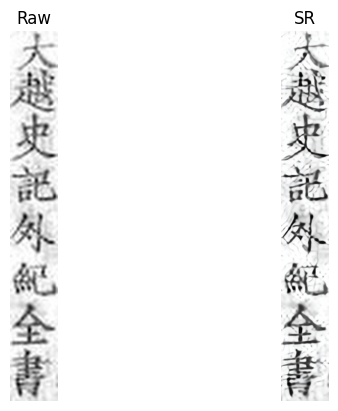

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('/content/Datasets/Patches/DVSKTT-1 Quyen thu/DVSKTT_thu_III_1a_0.jpg')

def change_image_size(img):
    h, w, _ = img.shape

    # Downsize image to height mod 64, width mod 16
    new_h = (h // 64) * 64
    new_w = (w // 16) * 16
    # try:
    #     img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LANCZOS4)
    # except:
    #     print(img.shape)
    if new_h != 0 and new_w != 0:
        img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LANCZOS4)
    else:
        img = cv2.resize(img, (16, 64), interpolation=cv2.INTER_LANCZOS4)

    return img

def slice_image(img):
    # Slice image into multiple (16, 64), return numpy array
    h, w, _ = img.shape
    slices = []
    for i in range(0, h, 64):
        for j in range(0, w, 16):
            slices.append(img[i:i+64, j:j+16, :])

    # n_slice = len(slices)
    # plt.figure()
    # plt.title('Slices_Raw')
    # for i in range(n_slice):
    #     plt.subplot(1, n_slice, i+1)
    #     plt.imshow(slices[i])
    #     plt.axis('off')
    # plt.show()

    slices = np.array(slices)

    return slices

def bgr2ycbcr(image: np.ndarray, only_use_y_channel: bool) -> np.ndarray:
    """Implementation of bgr2ycbcr function in Matlab under Python language.

    Args:
        image (np.ndarray): Image input in BGR format
        only_use_y_channel (bool): Extract Y channel separately

    Returns:
        image (np.ndarray): YCbCr image array data

    """
    if only_use_y_channel:
        image = np.dot(image, [24.966, 128.553, 65.481]) + 16.0
    else:
        image = np.matmul(image, [[24.966, 112.0, -18.214], [128.553, -74.203, -93.786], [65.481, -37.797, 112.0]]) + [
            16, 128, 128]

    image /= 255.
    image = image.astype(np.float32)

    return image

def image2tensor(image: np.ndarray, range_norm: bool, half: bool) -> torch.Tensor:
    """Convert the image data type to the Tensor (NCWH) data type supported by PyTorch

    Args:
        image (np.ndarray): The image data read by ``OpenCV.imread``, the data range is [0,255] or [0, 1]
        range_norm (bool): Scale [0, 1] data to between [-1, 1]
        half (bool): Whether to convert torch.float32 similarly to torch.half type

    Returns:
        tensor (torch.Tensor): Data types supported by PyTorch

    Examples:
        >>> example_image = cv2.imread("lr_image.bmp")
        >>> example_tensor = image2tensor(example_image, range_norm=True, half=False)

    """
    # Convert image data type to Tensor data type
    tensor = torch.tensor(image)

    # Scale the image data from [0, 1] to [-1, 1]
    if range_norm:
        tensor = tensor.mul(2.0).sub(1.0)

    # Convert torch.float32 image data type to torch.half image data type
    if half:
        tensor = tensor.half()

    return tensor

def ycbcr2bgr(image: np.ndarray) -> np.ndarray:
    """Implementation of ycbcr2bgr function in Matlab under Python language.

    Args:
        image (np.ndarray): Image input in YCbCr format.

    Returns:
        image (np.ndarray): BGR image array data

    """
    image_dtype = image.dtype
    image *= 255.

    image = np.matmul(image, [[0.00456621, 0.00456621, 0.00456621],
                              [0.00791071, -0.00153632, 0],
                              [0, -0.00318811, 0.00625893]]) * 255.0 + [-276.836, 135.576, -222.921]

    image /= 255.
    image = image.astype(image_dtype)

    return image

print(img.shape)
sr_model.to(DEVICE)

SCALE = 4

if sr_model.__class__.__name__ == 'EDSR':
    img_tensor = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).float().div(255).to(DEVICE)
    with torch.no_grad():
        output = sr_model(img_tensor).cpu()

        img_output = output.squeeze().permute(1, 2, 0).numpy()
        img_output = cv2.cvtColor(img_output, cv2.COLOR_RGB2BGR)
        print(img_output.shape)


if sr_model.__class__.__name__ == 'SRCNN':
    img_tmp = img.copy()
    h, w, _ = img_tmp.shape
    img_tmp = cv2.resize(img_tmp, (w * SCALE, h * SCALE), interpolation=cv2.INTER_LANCZOS4)
    img_tmp_y = bgr2ycbcr(img_tmp, only_use_y_channel=True)
    img_tmp_ycbcr = bgr2ycbcr(img_tmp, only_use_y_channel=False)
    _, img_tmp_cb, img_tmp_cr = cv2.split(img_tmp_ycbcr)


    img_tensor = image2tensor(img_tmp_y, False, False).unsqueeze(0).div(255).to(DEVICE)
    with torch.no_grad():
        output = sr_model(img_tensor).clamp(0, 1)

    sr_y_image = output.squeeze().mul(255).cpu().numpy().astype(np.uint8)
    sr_y_image = sr_y_image.astype(np.float32) / 255.0
    sr_ycbcr_image = cv2.merge((sr_y_image, img_tmp_cb, img_tmp_cr))
    sr_image = ycbcr2bgr(sr_ycbcr_image)
    img_output = sr_image
    print(img_output.shape)

    def srcnn_inference(img, model):
        img_tmp = img.copy()
        h, w, _ = img_tmp.shape
        img_tmp = cv2.resize(img_tmp, (w * SCALE, h * SCALE), interpolation=cv2.INTER_LANCZOS4)
        img_tmp_y = bgr2ycbcr(img_tmp, only_use_y_channel=True)
        img_tmp_ycbcr = bgr2ycbcr(img_tmp, only_use_y_channel=False)
        _, img_tmp_cb, img_tmp_cr = cv2.split(img_tmp_ycbcr)

        img_tensor = image2tensor(img_tmp_y, False, False).unsqueeze(0).div(255).to(DEVICE)
        with torch.no_grad():
            output = model(img_tensor).clamp(0, 1)

        sr_y_image = output.squeeze().mul(255).cpu().numpy().astype(np.uint8)
        sr_y_image = sr_y_image.astype(np.float32) / 255
        sr_ycbcr_image = cv2.merge((sr_y_image, img_tmp_cb, img_tmp_cr))
        sr_image = ycbcr2bgr(sr_ycbcr_image)
        img_output = sr_image
        return img_output

if sr_model.__class__.__name__ == 'TSRN':
    gray_mask = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_mask = cv2.threshold(gray_mask, np.array(gray_mask).mean(), 255, cv2.THRESH_BINARY)[1] / 255.0
    gray_mask = np.expand_dims(gray_mask, axis=-1)
    # print(gray_mask.shape)
    # Concat gray_mask and img
    img = img / 255.0
    img = np.concatenate([img, gray_mask], axis=2)
    # print(img.shape)

    img_tensor = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).float().to(DEVICE)

    with torch.no_grad():
        output = sr_model(img_tensor)
        # print(output.shape)

        img_output = output.squeeze()
        img_output = img_output.permute(1, 2, 0)
        print(img_output.shape)

        img_output = (img_output.numpy() * 255).astype(np.uint8)[:, :, :3]
        print(img_output.shape)
        img_output = cv2.cvtColor(img_output, cv2.COLOR_RGB2BGR)

if sr_model.__class__.__name__ == 'TBSRN':
    # Resize
    img = change_image_size(img)
    img_slices = slice_image(img)
    print(img_slices.shape)
    # Create batch tensor from image slices
    img_tensor = torch.from_numpy(img_slices).permute(0, 3, 1, 2).float().div(255).to(DEVICE)

    # print(img_tensor.shape)
    with torch.no_grad():
        output = sr_model(img_tensor).cpu()
        pass

    # Stack slices into one
    print(output.shape)

    output = torch.concat([o for o in output], axis=1)
    print(output.shape)

    img_output = output.squeeze().permute(1, 2, 0).mul(255).numpy().astype(np.uint8)
    print(img_output.shape)
    img_output = cv2.cvtColor(img_output, cv2.COLOR_RGB2BGR)

h, w, _ = img.shape
img = cv2.resize(img, (w * SCALE, h * SCALE), interpolation=cv2.INTER_LANCZOS4)

plt.figure()
plt.subplot(1, 2, 1)
plt.title('Raw')
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('SR')
plt.imshow(img_output)
plt.axis('off')
plt.show()

In [ ]:
TSRN_folder = '/content/TSRN_Dataset'
TBSRN_folder = '/content/TBSRN_Dataset'
SRCNN_folder = '/content/SRCNN_Dataset'
EDSR_folder = '/content/EDSR_Dataset'

if not os.path.exists(TSRN_folder):
    os.mkdir(TSRN_folder)
if not os.path.exists(TBSRN_folder):
    os.mkdir(TBSRN_folder)
if not os.path.exists(SRCNN_folder):
    os.mkdir(SRCNN_folder)
if not os.path.exists(EDSR_folder):
    os.mkdir(EDSR_folder)

import shutil
from tqdm.auto import tqdm
import cv2

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sr_model.to(DEVICE)

def copy_images(root_dir, target_dir):
    """
    Walks through root_dir to find image files and copies them to subdirectories in target_dir.

    Args:
        root_dir: The directory to search for images.
        target_dir: The directory to copy images to.
    """
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in tqdm(filenames):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                source_path = os.path.join(dirpath, filename)
                relative_path = os.path.relpath(dirpath, root_dir)
                target_subdir = os.path.join(target_dir, relative_path)
                os.makedirs(target_subdir, exist_ok=True)
                target_path = os.path.join(target_subdir, filename)

                # # Read and create TSRN-SR image
                # img = cv2.imread(source_path)
                # gray_mask = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                # gray_mask = cv2.threshold(gray_mask, np.array(gray_mask).mean(), 255, cv2.THRESH_BINARY)[1] / 255
                # gray_mask = np.expand_dims(gray_mask, axis=-1)
                # img = img / 255
                # img = np.concatenate([img, gray_mask], axis=2)
                # img_tensor = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).float().to(DEVICE)
                # with torch.no_grad():
                #     output = sr_model(img_tensor).cpu()
                #     img_output = output.squeeze()
                #     img_output = img_output.permute(1, 2, 0)
                #     img_output = (img_output.numpy() * 255).astype(np.uint8)[:, :, :3]
                #     cv2.imwrite(target_path, img_output)

                # # Read and create TBSRN-SR image
                # img = cv2.imread(source_path)
                # img = change_image_size(img)
                # img_slices = slice_image(img)
                # img_tensor = torch.from_numpy(img_slices).permute(0, 3, 1, 2).float().div(255).to(DEVICE)
                # with torch.no_grad():
                #     output = sr_model(img_tensor).cpu()
                #     output = torch.concat([o for o in output], axis=1)
                #     img_output = output.squeeze().permute(1, 2, 0).mul(255).numpy().astype(np.uint8)
                #     img_output = cv2.cvtColor(img_output, cv2.COLOR_RGB2BGR)
                #     cv2.imwrite(target_path, img_output)

                # # Read and create SRCNN-SR image
                # img = cv2.imread(source_path)
                # h, w, _ = img.shape
                # img = cv2.resize(img, (w * 2, h * 2), interpolation=cv2.INTER_LANCZOS4)
                # img_tmp_y = bgr2ycbcr(img, only_use_y_channel=True)
                # img_tmp_ycbcr = bgr2ycbcr(img, only_use_y_channel=False)
                # _, img_tmp_cb, img_tmp_cr = cv2.split(img_tmp_ycbcr)

                # img_tensor = image2tensor(img_tmp_y, False, False).unsqueeze(0).div(255).to(DEVICE)
                # with torch.no_grad():
                #     output = sr_model(img_tensor).clamp(0, 1)

                #     sr_y_image = output.squeeze().mul(255).cpu().numpy().astype(np.uint8)
                #     sr_y_image = sr_y_image.astype(np.float32) / 255
                #     sr_ycbcr_image = cv2.merge((sr_y_image, img_tmp_cb, img_tmp_cr))
                #     img_output = ycbcr2bgr(sr_ycbcr_image) * 255.0

                #     cv2.imwrite(target_path, img_output)

                # Read and create EDSR-SR image
                img = cv2.imread(source_path)
                h, w, _ = img.shape
                img_tensor = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).float().div(255).to(DEVICE)
                with torch.no_grad():
                    output = sr_model(img_tensor).cpu()
                    img_output = output.squeeze().permute(1, 2, 0).numpy()
                    img_output = cv2.cvtColor(img_output, cv2.COLOR_RGB2BGR)
                    cv2.imwrite(target_path, img_output * 255)

            # Copy text file
            if filename.lower().endswith('.txt'):
                shutil.copy(os.path.join(dirpath, filename), target_dir)


# Example usage:
root_dir = '/content/Datasets/Patches'
target_dir = EDSR_folder
copy_images(root_dir, target_dir)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7891 [00:00<?, ?it/s]

  0%|          | 0/11118 [00:00<?, ?it/s]

  0%|          | 0/929 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/2605 [00:00<?, ?it/s]

  0%|          | 0/2385 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3254 [00:00<?, ?it/s]

  0%|          | 0/4835 [00:00<?, ?it/s]

  0%|          | 0/2053 [00:00<?, ?it/s]

# Define the model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Bidirectional, GRU
import tensorflow as tf
from tensorflow.keras.layers import (
    Convolution2D, MaxPooling2D, BatchNormalization, Dense, Multiply,
    Activation, LeakyReLU, Reshape, Permute, Lambda, RepeatVector
)


def custom_cnn(config, image_input, alpha=0):
    # Generate Convolutional blocks by config
    for idx, (block_name, block_config) in enumerate(config.items()):
        num_conv, filters, pool_size = block_config.values()
        for conv_idx in range(1, num_conv + 1):
            x = Convolution2D(
                filters = filters,
                kernel_size = (3, 3) if pool_size else (2, 2),
                padding = 'same' if pool_size else 'valid',
                kernel_initializer = 'he_uniform',
                name = f'{block_name}_conv{conv_idx}'
            )(image_input if idx + conv_idx == 1 else x)

            x = BatchNormalization(name=f'{block_name}_bn{conv_idx}')(x)
            if alpha > 0: x = LeakyReLU(alpha, name=f'{block_name}_act{conv_idx}')(x)
            else: x = Activation('relu', name=f'{block_name}_relu{conv_idx}')(x)

        if pool_size is not None:
            x = MaxPooling2D(pool_size, name=f'{block_name}_pool')(x)
    return x


def reshape_features(last_cnn_layer, dim_to_keep=-1, name='cnn_features'):
    # Reshape accordingly before passing the output to the RNN or Transformer
    _, height, width, channel = last_cnn_layer.get_shape()
    if dim_to_keep == 1:
        target_shape = (height, width * channel)
    elif dim_to_keep == 2:
        target_shape = (width, height * channel)
    elif dim_to_keep == 3 or dim_to_keep == -1:
        target_shape = (height * width, channel)
    else:
        raise ValueError('Invalid dim_to_keep value')
    return Reshape(target_shape=(target_shape), name=name)(last_cnn_layer)


# https://pbcquoc.github.io/vietnamese-ocr (Vietnamese blog)
def visual_attention(feature_maps):
    _, timestep, input_dim = feature_maps.shape
    a = Permute((2, 1), name='dim_switching1')(feature_maps)
    a = Dense(timestep, activation='softmax', name='attention_scores')(a)
    a = Lambda(lambda x: tf.reduce_sum(x, axis=1), name='dim_reduction')(a)
    a = RepeatVector(input_dim, name='redistribute')(a)
    a = Permute((2, 1), name='dim_switching2')(a)
    return Multiply(name='context_vector')([feature_maps, a])


class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units, name='BahdanauAttention', **kwargs):
        super(BahdanauAttention, self).__init__(name=name, **kwargs)
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, enc_output, hidden):
        # encoder output shape == (batch_size, receptive_size, channels)
        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, receptive_size, units)
        attention_hidden_layer = self.W1(enc_output) + self.W2(hidden_with_time_axis)
        attention_hidden_layer = tf.nn.tanh(attention_hidden_layer)

        # score shape == (batch_size, receptive_size, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, receptive_size, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, channels)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights


class AdditiveAttention(tf.keras.layers.Layer):
    def __init__(self, units, name='AdditiveAttention', **kwargs):
        super(AdditiveAttention, self).__init__(name=name, **kwargs)
        self.W1 = Dense(units, use_bias=False)
        self.W2 = Dense(units, use_bias=False)
        self.attention = tf.keras.layers.AdditiveAttention()

    def call(self, query, value):
        w1_query, w2_key = self.W1(query), self.W2(value)
        context_vector, attention_weights = self.attention(
            inputs = [w1_query, value, w2_key],
            return_attention_scores = True,
        )
        return context_vector, attention_weights

In [ ]:
def build_crnn(imagenet_model=None, imagenet_output_layer=None, name='CRNN'):
    # CNN layers
    if imagenet_model: # Use Imagenet model as CNN layers
        image_input = imagenet_model.input
        imagenet_model.layers[0]._name = 'image'
        x = imagenet_model.get_layer(imagenet_output_layer).output
    else:
        image_input = Input(shape=(HEIGHT, WIDTH, 3), dtype='float32', name='image')
        conv_blocks_config = {
            'block1': {'num_conv': 1, 'filters':  64, 'pool_size': (2, 2)},
            'block2': {'num_conv': 1, 'filters': 128, 'pool_size': (2, 2)},
            'block3': {'num_conv': 2, 'filters': 256, 'pool_size': (2, 2)},
            'block4': {'num_conv': 2, 'filters': 512, 'pool_size': (2, 2)},

            # Last Conv blocks with 2x2 kernel but without padding and pooling layer
            'block5': {'num_conv': 2, 'filters': 512, 'pool_size': None},
        }
        x = custom_cnn(conv_blocks_config, image_input)

    # Reshape accordingly before passing output to RNN
    feature_maps = reshape_features(x, dim_to_keep=1, name='rnn_input')

    # RNN layers
    bigru1 = Bidirectional(GRU(256, return_sequences=True), name='bigru1')(feature_maps)
    bigru2 = Bidirectional(GRU(256, return_sequences=True), name='bigru2')(bigru1)

    # Output layer
    y_pred = Dense(
        units = VOCAB_SIZE + 1, # + 1 blank character for CTC loss
        activation = 'softmax',
        name = 'rnn_output'
    )(bigru2)
    return Model(inputs=image_input, outputs=y_pred, name=name)

In [ ]:
# https://www.tensorflow.org/text/tutorials/nmt_with_attention
# https://www.tensorflow.org/tutorials/text/image_captioning
import tensorflow as tf
from tensorflow.keras.models import clone_model
from abc import abstractmethod, ABCMeta # For define pure virtual functions


def get_imagenet_model(model_name, input_shape):
    # Pick a model from https://keras.io/api/applications
    base_model = eval('tf.keras.applications.' + model_name)
    return base_model(input_shape=input_shape, weights=None, include_top=False)


class CustomTrainingModel(tf.keras.Model, metaclass=ABCMeta):
    def __init__(self, data_handler=None, name='CustomTrainingModel', **kwargs):
        super(CustomTrainingModel, self).__init__(name=name, **kwargs)
        self.data_handler = data_handler


    def get_config(self):
        raise NotImplementedError() # To return model components when using clone_model


    @classmethod
    def from_config(cls, config):
        return cls(**config) # To clone model when using kfold training


    @abstractmethod
    def _compute_loss_and_metrics(self, batch, is_training=False):
        pass # Pure virtual functions => Must be overridden in the derived classes


    @abstractmethod
    def predict(self, batch_images):
        pass # Pure virtual functions => Must be overridden in the derived classes


    @tf.function
    def train_step(self, batch):
        with tf.GradientTape() as tape:
            loss, display_results = self._compute_loss_and_metrics(batch, is_training=True)

        # Apply an optimization step
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return display_results


    @tf.function
    def test_step(self, batch):
        _, display_results = self._compute_loss_and_metrics(batch)
        return display_results


    @tf.function
    def _update_metrics(self, batch):
        batch_images, batch_tokens = batch
        predictions = self.predict(batch_images)
        self.compiled_metrics.update_state(batch_tokens, predictions)
        return {m.name: m.result() for m in self.metrics}


    @tf.function
    def _init_seq_tokens(self, batch_size, return_new_tokens=True):
        seq_tokens = tf.fill([batch_size, self.data_handler.max_length], self.data_handler.start_token)
        seq_tokens = tf.cast(seq_tokens, dtype=tf.int64)
        new_tokens = tf.fill([batch_size, 1], self.data_handler.start_token)
        new_tokens = tf.cast(new_tokens, dtype=tf.int64)

        seq_tokens = update_tensor_column(seq_tokens, new_tokens, 0)
        done = tf.zeros([batch_size, 1], dtype=tf.bool)
        if not return_new_tokens: return seq_tokens, done
        return seq_tokens, new_tokens, done


    @tf.function
    def _update_seq_tokens(self, y_pred, seq_tokens, done, pos_idx, return_new_tokens=True):
        # Set the logits for all masked tokens to -inf, so they are never chosen
        y_pred = tf.where(self.data_handler.token_mask, float('-inf'), y_pred)
        new_tokens = tf.argmax(y_pred, axis=-1)

        # Add batch dimension if it is not present after argmax
        if tf.rank(new_tokens) == 1: new_tokens = tf.expand_dims(new_tokens, axis=1)

        # Once a sequence is done it only produces padding token
        new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)
        seq_tokens = update_tensor_column(seq_tokens, new_tokens, pos_idx)

        # If a sequence produces an `END_TOKEN`, set it `done` after that
        done = done | (new_tokens == self.data_handler.end_token)
        if not return_new_tokens: return seq_tokens, done
        return seq_tokens, new_tokens, done


class EncoderDecoderModel(CustomTrainingModel):
    def __init__(
        self,
        encoder: tf.keras.Model,
        decoder: tf.keras.Model,
        data_handler = None, # DataHandler instance
        dec_rnn_name = '', # Use if there is no rnn in the encoder
        name = 'EncoderDecoderModel',
        **kwargs
    ):
        super(EncoderDecoderModel, self).__init__(data_handler, name, **kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.dec_rnn_name = dec_rnn_name


    def get_config(self):
        return{
            'encoder': clone_model(self.encoder),
            'decoder': clone_model(self.decoder),
            'dec_rnn_name': self.dec_rnn_name,
            'data_handler': self.data_handler
        }


    @tf.function
    def _compute_loss_and_metrics(self, batch, is_training=False):
        batch_images, batch_tokens = batch
        batch_size = batch_images.shape[0]
        loss = tf.constant(0.0)

        dec_input = tf.expand_dims([self.data_handler.start_token] * batch_size, 1)
        if self.dec_rnn_name: # If there is no rnn in encoder, the hidden state will be initialized with 0
            enc_output = self.encoder(batch_images, training=is_training)
            dec_units = self.decoder.get_layer(self.dec_rnn_name).units
            hidden = tf.zeros((batch_size, dec_units), dtype=tf.float32)
        else: enc_output, hidden = self.encoder(batch_images, training=is_training)

        for i in range(1, self.data_handler.max_length):
            # Passing the features through the decoder
            y_pred, hidden, _ = self.decoder([dec_input, enc_output, hidden], training=is_training)
            loss += self.loss(batch_tokens[:, i], y_pred)
            dec_input = tf.expand_dims(batch_tokens[:, i], 1) # Use teacher forcing

        # Update training display result
        metrics = self._update_metrics(batch)
        return loss, {'loss': loss / self.data_handler.max_length, **metrics}


    @tf.function
    def predict(self, batch_images, return_attention=False):
        batch_size = batch_images.shape[0]
        seq_tokens, new_tokens, done = self._init_seq_tokens(batch_size)
        attentions = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)

        if self.dec_rnn_name:
            enc_output = self.encoder(batch_images, training=False)
            dec_units = self.decoder.get_layer(self.dec_rnn_name).units
            hidden = tf.zeros((batch_size, dec_units), dtype=tf.float32)
        else: enc_output, hidden = self.encoder(batch_images, training=False)

        for i in range(1, self.data_handler.max_length):
            y_pred, hidden, attention_weights = self.decoder([new_tokens, enc_output, hidden], training=False)
            attentions = attentions.write(i - 1, attention_weights)
            seq_tokens, new_tokens, done = self._update_seq_tokens(y_pred, seq_tokens, done, i)
            if tf.executing_eagerly() and tf.reduce_all(done): break

        if not return_attention: return seq_tokens
        return seq_tokens, tf.transpose(tf.squeeze(attentions.stack()), [1, 0, 2])


class EarlyBindingCaptioner(CustomTrainingModel):
    def __init__(
        self,
        cnn_block: tf.keras.Model,
        rnn_block: tf.keras.Model,
        data_handler = None, # DataHandler instance
        name = 'EarlyBindingCaptioner',
        **kwargs
    ):
        super(EarlyBindingCaptioner, self).__init__(data_handler, name, **kwargs)
        self.cnn_block = cnn_block
        self.rnn_block = rnn_block


    def get_config(self):
        return {
            'cnn_block': clone_model(self.cnn_block),
            'rnn_block': clone_model(self.rnn_block),
            'data_handler': self.data_handler,
        }


    @tf.function
    def _loop(self, batch_images, batch_tokens=None, is_training=False):
        batch_size = batch_images.shape[0]
        seq_tokens, done = self._init_seq_tokens(batch_size, return_new_tokens=False)
        features = self.cnn_block(batch_images, training=is_training)
        loss = tf.constant(0.0)

        for i in range(1, self.data_handler.max_length):
            y_pred = self.rnn_block([seq_tokens[:, :-1], features], training=is_training)
            seq_tokens, done = self._update_seq_tokens(y_pred, seq_tokens, done, i, return_new_tokens=False)
            if batch_tokens is not None: loss += self.loss(batch_tokens[:, i], y_pred) # Is training
            elif tf.executing_eagerly() and tf.reduce_all(done): break # Is predicting

        if batch_tokens is None: return seq_tokens
        return loss / self.data_handler.max_length


    @tf.function
    def _compute_loss_and_metrics(self, batch, is_training=False):
        batch_images, batch_tokens = batch
        loss = self._loop(batch_images, batch_tokens, is_training)
        metrics = self._update_metrics(batch) # Update training display result
        return loss, {'loss': loss, **metrics}


    @tf.function
    def predict(self, batch_images):
        return self._loop(batch_images)
imagenet_model, imagenet_output_layer = None, None
# # Pick a model from https://keras.io/api/applications
# imagenet_model = get_imagenet_model('VGG16', (HEIGHT, WIDTH, 3))
# imagenet_output_layer = 'block5_pool'
# imagenet_model.summary(line_length=100)

In [ ]:
model = build_crnn(imagenet_model, imagenet_output_layer)
model.summary(line_length=110)

Model: "CRNN"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 image (InputLayer)                              [(None, 432, 48, 3)]                        0                
                                                                                                              
 block1_conv1 (Conv2D)                           (None, 432, 48, 64)                         1792             
                                                                                                              
 block1_bn1 (BatchNormalization)                 (None, 432, 48, 64)                         256              
                                                                                                              
 block1_relu1 (Activation)                       (None, 432, 48, 64)                         0    

# Training

In [ ]:
# train_idxs = list(range(100))
# valid_idxs = list(range(100, 150))
# print('Number of training samples:', len(train_idxs))
# print('Number of validate samples:', len(valid_idxs))

train_idxs = list(range(dataset.size - NUM_VALIDATE))
valid_idxs = list(range(train_idxs[-1] + 1, dataset.size))
print('Number of training samples:', len(train_idxs))
print('Number of validate samples:', len(valid_idxs))

Number of training samples: 60518
Number of validate samples: 15154


In [ ]:
import random
random.seed(2022)
random.shuffle(train_idxs)

# When run on a small RAM machine, you can set use_cache=False to
# not run out of memory but it will slow down the training speed
train_tf_dataset = data_handler.prepare_tf_dataset(train_idxs, BATCH_SIZE)
valid_tf_dataset = data_handler.prepare_tf_dataset(valid_idxs, BATCH_SIZE)

## Callbacks

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_callback = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 1e-3, # Change that less than 1e-3, will count as no improvement
    patience = 5, # Stop if no improvement after 5 epochs
    restore_best_weights = True, # Restore weights from the epoch with the best value
    verbose = 1
)

## Train the NomNaOCR dataset

In [ ]:
class CTCLoss(tf.keras.losses.Loss):
    def __init__(self, name='ctc_loss', **kwargs):
        super(CTCLoss, self).__init__(name=name, **kwargs)
        self.loss = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        label_length = tf.cast(y_true != 0, tf.int64)
        label_length = tf.expand_dims(tf.reduce_sum(label_length, axis=-1), axis=1)

        batch_length = tf.cast(tf.shape(y_true)[0], tf.int64)
        pred_length = tf.cast(tf.shape(y_pred)[1], tf.int64)
        pred_length *= tf.ones((batch_length, 1), tf.int64)
        return self.loss(y_true, y_pred, pred_length, label_length)
class SequenceAccuracy(tf.keras.metrics.Metric):
    def __init__(
        self,
        use_ctc_decode = False, # Need to decode predictions if CTC loss used,
        name = 'seq_acc',
        **kwargs
    ):
        super(SequenceAccuracy, self).__init__(name=name, **kwargs)
        self.use_ctc_decode = use_ctc_decode
        self.count = self.add_weight(name='count', initializer='zeros')
        self.total = self.add_weight(name='total', initializer='zeros')

    def update_state(self, y_true, y_pred, **kwargs):
        batch_size, max_length = tf.shape(y_true)[0], tf.shape(y_true)[1]
        if self.use_ctc_decode: y_pred = ctc_decode(y_pred, max_length)

        # Get a single batch and convert its labels to sparse tensors.
        sparse_true = tokens2sparse(y_true)
        sparse_pred = tokens2sparse(y_pred)

        y_true = sparse2dense(sparse_true, [batch_size, max_length])
        y_pred = sparse2dense(sparse_pred, [batch_size, max_length])

        num_errors = tf.reduce_any(y_true != y_pred, axis=1)
        num_errors = tf.reduce_sum(tf.cast(num_errors, tf.float32))
        total = tf.cast(batch_size, tf.float32)

        self.count.assign_add(total - num_errors)
        self.total.assign_add(total)

    def result(self):
        return tf.math.divide_no_nan(self.count, self.total)

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.count.assign(0)
        self.total.assign(0)
class CharacterAccuracy(tf.keras.metrics.Metric):
    def __init__(
        self,
        use_ctc_decode = False, # Need to decode predictions if CTC loss used,
        name = 'char_acc',
        **kwargs
    ):
        super(CharacterAccuracy, self).__init__(name=name, **kwargs)
        self.use_ctc_decode = use_ctc_decode
        self.count = self.add_weight(name='count', initializer='zeros')
        self.total = self.add_weight(name='total', initializer='zeros')

    def update_state(self, y_true, y_pred, **kwargs):
        batch_size, max_length = tf.shape(y_true)[0], tf.shape(y_true)[1]
        if self.use_ctc_decode: y_pred = ctc_decode(y_pred, max_length)

        num_errors = tf.logical_and(y_true != y_pred, y_true != 0)
        num_errors = tf.reduce_sum(tf.cast(num_errors, tf.float32))
        total = tf.reduce_sum(tf.cast(y_true != 0, tf.float32))

        self.count.assign_add(total - num_errors)
        self.total.assign_add(total)

    def result(self):
        return tf.math.divide_no_nan(self.count, self.total)

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.count.assign(0)
        self.total.assign(0)
class LevenshteinDistance(tf.keras.metrics.Metric):
    def __init__(
        self,
        use_ctc_decode = False, # Need to decode predictions if CTC loss used,
        normalize = False, # If True, this becomes Character Error Rate: CER = (S + D + I) / N
        name = 'levenshtein_distance',
        **kwargs
    ):
        super(LevenshteinDistance, self).__init__(name=name, **kwargs)
        self.use_ctc_decode = use_ctc_decode
        self.normalize = normalize
        self.sum_distance = self.add_weight(name='sum_distance', initializer='zeros')
        self.total = self.add_weight(name='total', initializer='zeros')

    def update_state(self, y_true, y_pred, **kwargs):
        batch_size, max_length = tf.shape(y_true)[0], tf.shape(y_true)[1]
        if self.use_ctc_decode: y_pred = ctc_decode(y_pred, max_length)

        # Get a single batch and convert its labels to sparse tensors.
        sparse_true = tokens2sparse(y_true)
        sparse_pred = tokens2sparse(y_pred)

        # Explain tf.edit_distance: https://stackoverflow.com/questions/51612489
        edit_distances = tf.edit_distance(sparse_pred, sparse_true, normalize=self.normalize)
        self.sum_distance.assign_add(tf.reduce_sum(edit_distances))
        self.total.assign_add(tf.cast(batch_size, tf.float32))

    def result(self):
        # Computes and returns a scalar value for the metric
        return tf.math.divide_no_nan(self.sum_distance, self.total)

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.sum_distance.assign(0)
        self.total.assign(0)


# https://github.com/solivr/tf-crnn/blob/master/tf_crnn/model.py#L157
# The result of this function is the same as that of the
# LevenshteinDistance metric above with normalize = True
def warp_cer_metric(y_true, y_pred, use_ctc_decode=False):
    ''' How to use:
    from tensorflow.keras.metrics import MeanMetricWrapper
    cer = MeanMetricWrapper(lambda y_true, y_pred: warp_cer_metric(
        y_true, y_pred, use_ctc_decode=True
    ), name='cer')
    '''
    if use_ctc_decode: y_pred = ctc_decode(y_pred, tf.shape(y_true)[1])
    y_true = tf.cast(y_true, tf.int64)

    # Get a single batch and convert its labels to sparse tensors.
    sparse_true = tokens2sparse(y_true)
    sparse_pred = tokens2sparse(y_pred)

    # Explain tf.edit_distance: https://stackoverflow.com/questions/51612489
    edit_distances = tf.edit_distance(sparse_pred, sparse_true, normalize=False)

    # Compute edit distance and total chars count
    sum_distance = tf.reduce_sum(edit_distances)
    count_chars = tf.reduce_sum(tf.cast(y_true != 0, tf.float32))
    return tf.math.divide_no_nan(sum_distance, count_chars, name='cer')
from tensorflow.keras.optimizers import Adadelta

# Adadelta tends to benefit from higher initial learning rate values compared to
# other optimizers. Here use 1.0 to match the exact form in the original paper
LEARNING_RATE = 1.0
EPOCHS = 100

In [ ]:
# model.load_weights(f'/content/Weights/Text recognition/CRNNxCTC/NomNaOCR/NomNaOCR_CRNNxCTC.h5')
model.compile(
    optimizer = Adadelta(LEARNING_RATE),
    loss = CTCLoss(),
    metrics = [
        SequenceAccuracy(use_ctc_decode=True),
        CharacterAccuracy(use_ctc_decode=True),
        LevenshteinDistance(use_ctc_decode=True, normalize=True)
    ]
)

In [ ]:
%%time
history = model.fit(
    train_tf_dataset,
    validation_data = valid_tf_dataset,
    epochs = EPOCHS,
    callbacks = [early_stopping_callback],
    verbose = 1
).history

Epoch 1/100
946/946 [==============================] - 365s 376ms/step - loss: 64.3554 - seq_acc: 0.0092 - char_acc: 0.1299 - levenshtein_distance: 0.8522 - val_loss: 44.1042 - val_seq_acc: 0.0183 - val_char_acc: 0.3000 - val_levenshtein_distance: 0.6757
Epoch 2/100
946/946 [==============================] - 322s 341ms/step - loss: 27.2059 - seq_acc: 0.0674 - char_acc: 0.5719 - levenshtein_distance: 0.4211 - val_loss: 24.0459 - val_seq_acc: 0.0681 - val_char_acc: 0.5739 - val_levenshtein_distance: 0.3890
Epoch 3/100
946/946 [==============================] - 323s 341ms/step - loss: 14.4788 - seq_acc: 0.1695 - char_acc: 0.7705 - levenshtein_distance: 0.2266 - val_loss: 16.4139 - val_seq_acc: 0.1505 - val_char_acc: 0.7155 - val_levenshtein_distance: 0.2578
Epoch 4/100
946/946 [==============================] - 323s 341ms/step - loss: 9.9090 - seq_acc: 0.2763 - char_acc: 0.8428 - levenshtein_distance: 0.1549 - val_loss: 11.9086 - val_seq_acc: 0.2167 - val_char_acc: 0.7943 - val_levenshtei

## Save the training results

In [ ]:
best_epoch = early_stopping_callback.best_epoch
print(f'- Loss on validation\t: {history["val_loss"][best_epoch]}')
print(f'- Sequence accuracy\t: {history["val_seq_acc"][best_epoch]}')
print(f'- Character accuracy\t: {history["val_char_acc"][best_epoch]}')
print(f'- Levenshtein distance\t: {history["val_levenshtein_distance"][best_epoch]}')

- Loss on validation	: 0.48897528648376465
- Sequence accuracy	: 0.9181074500083923
- Character accuracy	: 0.9870191216468811
- Levenshtein distance	: 0.01591498591005802


In [ ]:
plot_training_results(history, f'{APPROACH_NAME}.png')
model.save_weights(f'{APPROACH_NAME}.h5')

NameError: name 'plot_training_results' is not defined

# Inference

In [ ]:
!unzip -q "/content/drive/MyDrive/Thesis Resource/NomNaOCR/Data/weights.zip" -d /content/Weights

In [ ]:
reset_model = build_crnn(imagenet_model, imagenet_output_layer)
reset_model.load_weights(f'/content/Weights/Text recognition/CRNNxCTC/Fine-tuning/finetune_CRNNxCTC.h5')
reset_model.summary(line_length=110)

Model: "CRNN"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 image (InputLayer)                              [(None, 432, 48, 3)]                        0                
                                                                                                              
 block1_conv1 (Conv2D)                           (None, 432, 48, 64)                         1792             
                                                                                                              
 block1_bn1 (BatchNormalization)                 (None, 432, 48, 64)                         256              
                                                                                                              
 block1_relu1 (Activation)                       (None, 432, 48, 64)                         0    

In [ ]:
reset_model.compile(
    optimizer = Adadelta(LEARNING_RATE),
    loss = CTCLoss(),
    metrics = [
        SequenceAccuracy(use_ctc_decode=True),
        CharacterAccuracy(use_ctc_decode=True),
        LevenshteinDistance(use_ctc_decode=True, normalize=True)
    ]
)

## On test dataset

2/2 [==============================] - 4s 9ms/step
Batch 01:
- True: {1: '使通好執事迷而不反我是以有徃年之師帝遣', 2: '池有大蛇入見二十日上以砲旗皷制之賜月', 3: '非傾人宗祧若是其幾無所不至以致大明之疑', 4: '十一月戊辰朔日有食以裴時亨密奏故不之', 5: '使人追之不及十三日卯時克終自元軍回賊', 6: '冬十一月皇太子即皇帝位大赦以明年爲景', 7: '於民何以居人上宜早除之帝自知其然而心', 8: '使養之其人曰每月用藥所費百金三年方效王', 9: '一士王之時雖有守任然王以諸侯當國國人皆', 10: '安生王子國峻奪之公主㱕于國峻是月十五日', 11: '項郎尤鍾愛之立爲太子璉以是不平使人陰殺', 12: '其才品有高下之不同然亦莫不各得其人以', 13: '是龍鋌求爲太子帝欲許之廷臣議以爲不立長', 14: '取陶儼等三十六人廷試上親問以君師之道', 15: '日還國雖曰人謀之不滅是亦天運之有数也夫', 16: '之以本月十九日遷塟于御天之羙舍鄕二十', 17: '博覽副之卒定三年一貢為常例二月二十四', 18: '京恐為不便帝從之故有是命令明人著京', 19: '鄕人也以太祖起義六年癸卯冬十一月二', 20: '献六眸龟胷中有籒文二行群臣辨之成王以公', 21: '為阮朝且絶民之望李氏也秋七月二十二日', 22: '柰等二十員人入鳯\U000f0029堂帝自命題試之九日', 23: '府每以日燏子孫爲之如國康之於演州是也', 24: '納之乃拜二人為鎮殿副將軍令五府軍以陣圖', 25: '進上皇嘉之賜田四十𤱈以為後日脩行之資延', 26: '二十七日旨社置社官大社一百人以上用三', 27: '精氣因結為此故也世人以不常見而異之殊', 28: '元豊年間木印帖子者閲定官以為僞上皇聞之', 29: '天子之兆至是帝以甲戌年生為天子果', 30: '夏四月旱二十三日祈于昊天上帝以自冬迄', 31: '之曰何日擒獲䦕内人其事始和帝知意不解', 32: '甚長非我國之灾復命終宴是年冬十月宋帝崩', 33: '日月以之復明生民以之莫安國家以之順治由', 34: '統再三勸進朕不得以迺於今年十月初七日', 35: '之師其可以乎盖正其罪名也苟云遠人不服', 36: '不許獨見而

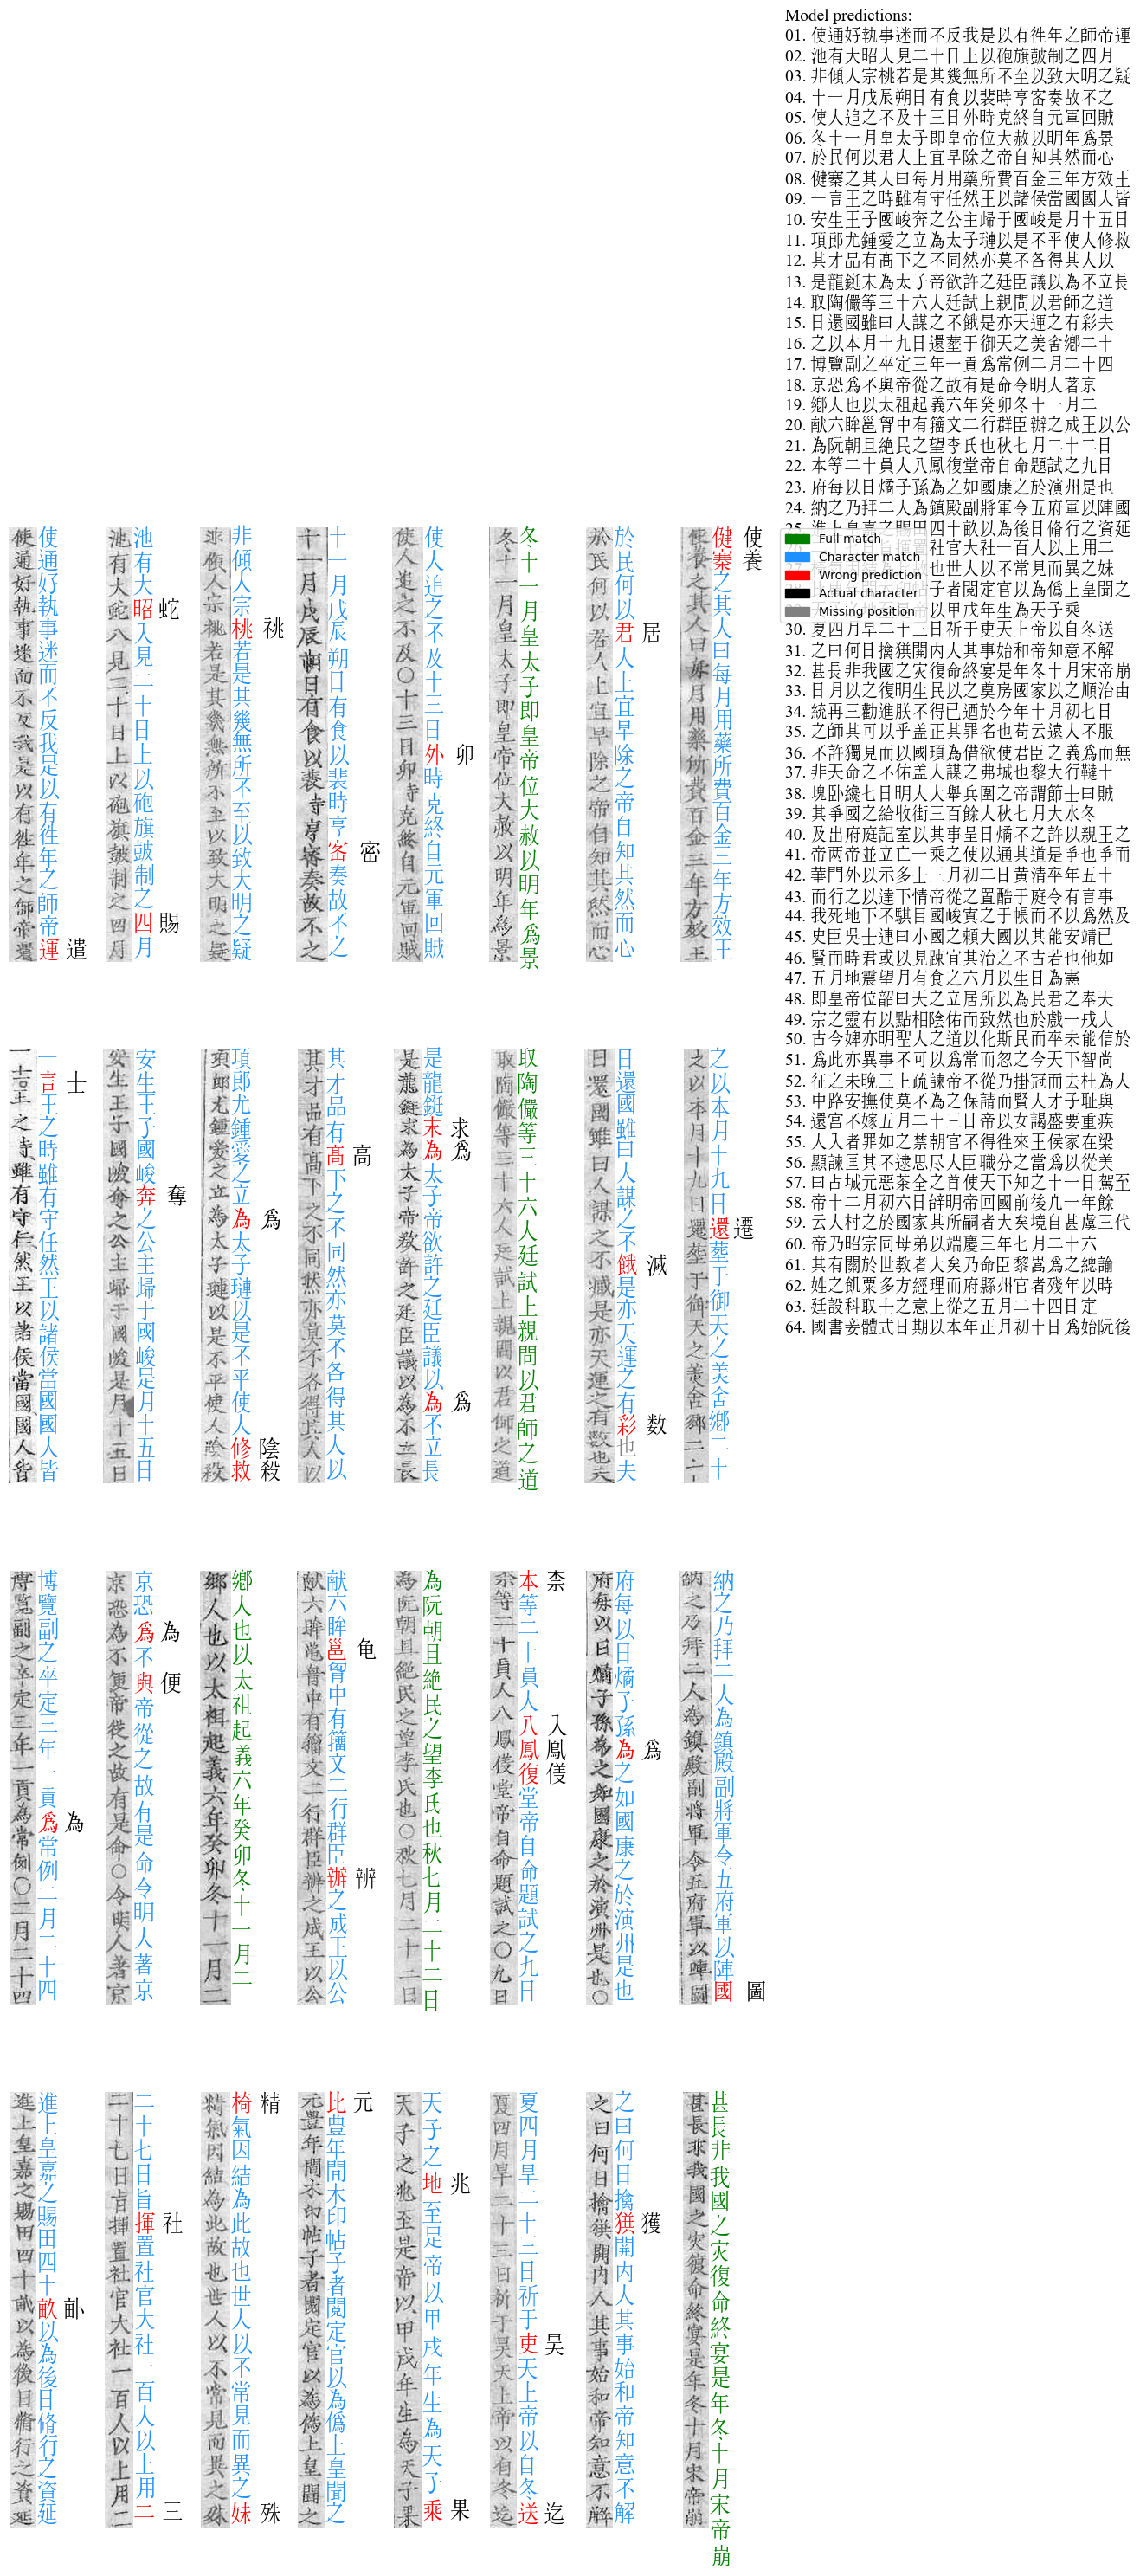

In [ ]:
for idx, (batch_images, batch_tokens) in enumerate(valid_tf_dataset.take(1)):
    idxs_in_batch = valid_idxs[idx * BATCH_SIZE: (idx + 1) * BATCH_SIZE]
    labels = data_handler.tokens2texts(batch_tokens)
    pred_tokens = reset_model.predict(batch_images)
    pred_labels = data_handler.tokens2texts(pred_tokens, use_ctc_decode=True)

    visualize_images_labels(
        img_paths = dataset.img_paths[idxs_in_batch],
        labels = labels,
        pred_labels = pred_labels,
        figsize = (11.6, 30),
        subplot_size = (4, 8),
        legend_loc = (3.8, 4.38),
        annotate_loc = (4, 2.75),
        font_path = FONT_PATH,
    )
    print(
        f'Batch {idx + 1:02d}:\n'
        f'- True: {dict(enumerate(labels, start=1))}\n'
        f'- Pred: {dict(enumerate(pred_labels, start=1))}\n'
    )

# Detail evaluation

In [ ]:
import pandas as pd
import os
import csv
import tensorflow as tf
from tqdm import tqdm


class Evaluator:
    def __init__(self, model, dataset_dir, transcripts_path):
        self.model = model
        self.dataset = DataImporter(dataset_dir, transcripts_path, min_length=1)
        self.tf_dataset = None


    def evaluate(self, data_handler, batch_size, drop_remainder=False):
        self.tf_dataset = tf.data.Dataset.from_tensor_slices((self.dataset.img_paths, self.dataset.labels))
        self.tf_dataset = self.tf_dataset.map(
            lambda img_path, label: (
                data_handler.process_image(img_path),
                data_handler.process_label(label)
            ), num_parallel_calls = tf.data.AUTOTUNE
        ).batch(batch_size, drop_remainder=drop_remainder)

        self.data_handler = data_handler
        self.tf_dataset = self.tf_dataset.cache().prefetch(tf.data.AUTOTUNE)
        return self.model.evaluate(self.tf_dataset, return_dict=True)


    def write_csv(self, file_name, use_ctc_decode=False):
        assert self.tf_dataset, "evaluate() method need to be run first"
        with open(file_name, 'w', encoding='utf-8', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['img_paths', 'labels', 'pred_labels'])

            for idx, (batch_images, batch_tokens) in tqdm(enumerate(self.tf_dataset)):
                labels = self.data_handler.tokens2texts(batch_tokens)
                pred_tokens = self.model.predict(batch_images)
                pred_labels = self.data_handler.tokens2texts(pred_tokens, use_ctc_decode)

                batch_size = len(batch_images)
                paths = self.dataset.img_paths[idx * batch_size: (idx + 1) * batch_size]
                paths = ['/'.join(os.path.abspath(path).split(os.path.sep)[-2:]) for path in paths]
                writer.writerows(list(map(list, zip(*[paths, labels, pred_labels]))))
GT10_TRANSCRIPTS_PATH = f'{DATASET_DIR}/Validate_gt10.txt'
LTE10_TRANSCRIPTS_PATH = f'{DATASET_DIR}/Validate_lte10.txt'

In [ ]:
gt10_evaluator = Evaluator(reset_model, DATASET_DIR, GT10_TRANSCRIPTS_PATH)
lte10_evaluator = Evaluator(reset_model, DATASET_DIR, LTE10_TRANSCRIPTS_PATH)
df = pd.DataFrame([
    reset_model.evaluate(valid_tf_dataset, return_dict=True),
    gt10_evaluator.evaluate(data_handler, BATCH_SIZE),
    lte10_evaluator.evaluate(data_handler, BATCH_SIZE),
])
df.index = ['Full', 'Length > 10', 'Length ≤ 10']
df